In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.keras import TqdmCallback
import glob
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from sklearn import preprocessing
from collections import Counter
from numpy import where
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
import keras.backend as K
import scipy

os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

In [2]:
output_path = "/content/drive/MyDrive/labelled data/"

#omit participant p02, p18 and p20
participants = ["p" + str(i).zfill(2) for i in range(0, 25) if i != 2 and i != 18 and i != 20]
print(participants)

['p00', 'p01', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p19', 'p21', 'p22', 'p23', 'p24']


#**Pre-processing with StandardScaler()**

In [ ]:
def s(samples):
    #print(samples)
    std = np.std(samples)
    if std == 0:
        return samples - np.mean(samples)
    else:
        return (samples - np.mean(samples)) / std

def preprocess(df):
  scaler = preprocessing.StandardScaler() #MinMaxScaler
  names = df.columns
  fit = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(fit, columns=names)
  return scaled_df

#**Segmentation with window size 30 (without overlap)**

#**All features sampled at 4Hz**

In [ ]:
eda_freq = 4

#without overlap
def get_data(pid):
    
    for f in os.listdir(output_path):
        if f.startswith(str(pid)) and f.endswith("EDA.csv"):
            eda_path = f
        elif f.startswith(str(pid)) and f.endswith("TEMP.csv"):
            temp_path = f
        elif f.startswith(str(pid)) and f.endswith("BVP.csv"):
            bvp_path = f
        elif f.startswith(str(pid)) and f.endswith("HR.csv"):
            hr_path = f
        elif f.startswith(str(pid)) and f.endswith("ACC.csv"):
            acc_path = f

    eda_data_raw = pd.read_csv(output_path + eda_path)
    temp_data_raw_all = pd.read_csv(output_path + temp_path)
    bvp_data_raw_all = pd.read_csv(output_path + bvp_path)
    hr_data_raw_all = pd.read_csv(output_path + hr_path)
    acc_data_raw_all = pd.read_csv(output_path + acc_path)

    bvp_data_raw_arr = scipy.signal.resample(bvp_data_raw_all['bvp'], len(eda_data_raw['eda']))
    temp_data_raw_arr = scipy.signal.resample(temp_data_raw_all['temp'], len(eda_data_raw['eda']))
    hr_data_raw_arr = scipy.signal.resample(hr_data_raw_all['bpm'], len(eda_data_raw['eda']))
    acc_x_data_raw_arr = scipy.signal.resample(acc_data_raw_all['x'], len(eda_data_raw['eda']))
    acc_y_data_raw_arr = scipy.signal.resample(acc_data_raw_all['y'], len(eda_data_raw['eda']))
    acc_z_data_raw_arr = scipy.signal.resample(acc_data_raw_all['z'], len(eda_data_raw['eda']))

    df_bvp = pd.DataFrame(bvp_data_raw_arr, columns = ['bvp'])
    df_temp = pd.DataFrame(temp_data_raw_arr, columns = ['temp'])
    df_hr = pd.DataFrame(hr_data_raw_arr, columns = ['bpm'])
    df_acc_x = pd.DataFrame(acc_x_data_raw_arr, columns = ['x'])
    df_acc_y = pd.DataFrame(acc_y_data_raw_arr, columns = ['y'])
    df_acc_z = pd.DataFrame(acc_z_data_raw_arr, columns = ['z'])
    df_eda = pd.DataFrame(eda_data_raw['eda'], columns= ['eda'])

    eda_data = preprocess(df_eda)
    temp_data = preprocess(df_temp)
    bvp_data = preprocess(df_bvp)
    hr_data = preprocess(df_hr)
    acc_x_data = preprocess(df_acc_x)
    acc_y_data = preprocess(df_acc_y)
    acc_z_data = preprocess(df_acc_z)

    data_merged = pd.concat([eda_data, temp_data, bvp_data, acc_x_data, acc_y_data, acc_z_data], axis=1)

    data_as_np = data_merged.to_numpy() 

    win_size = 30; X=[]; label=[];

    for i in range(win_size, int(len(eda_data_raw['eda']) / eda_freq)):

        X.append(s(data_as_np[eda_freq * (i - win_size): eda_freq * i]))

        l = eda_data_raw["label"][eda_freq * (i - win_size): eda_freq * i]
        lp = np.bincount(np.array(l)).argmax()
        label.append(lp)
    
    return { "data": np.array(X, dtype=object), 
            "label": np.array(label)}

In [ ]:
all_data = [get_data(pid) for pid in participants]

In [ ]:
for i in range(len(all_data)):
        print(all_data[i]['data'].shape)
        print(all_data[i]['label'].shape)

In [ ]:
scores = []
acc_per_sub, loss_per_sub = [], []
f1_per_sub, prec_per_sub, rec_per_sub = [], [], []
conf_matrix_per_sub = []

#**LSTM model**

#**Reshape, fit and evaluate the model**

In [ ]:
def lstm(train_data, test_data):

    models = []
    
    X_train = [] 
    X_train = train_data['data'].astype(np.float32) 
    y_train = train_data["label"]

    X_test = []
    X_test = test_data['data'].astype(np.float32) 
    y_test = test_data["label"]
    
    input = keras.layers.Input(shape=(train_data['data'].shape[1], train_data['data'].shape[2]))

    conv1d = keras.layers.Conv1D(32*2, 7)(input)
    lstm = keras.layers.LSTM(units=384)(conv1d)

    dense_layer_1 = keras.layers.Dense(64, activation="swish")(lstm)
    dense_layer_2 = keras.layers.Dense(100, activation="relu")(dense_layer_1)
    dropout = keras.layers.Dropout(0.05)(dense_layer_2)
    
    output_layer = keras.layers.Dense(3, activation="softmax")(dropout)

    model = tf.keras.Model(inputs=input, outputs=output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", 
                  metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=30, batch_size=128, 
                         validation_data=(X_test, y_test), verbose=0) 
    scores = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print(f'Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

    acc_per_sub.append(scores[1] * 100)
    loss_per_sub.append(scores[0])

    y_pred = np.argmax(model.predict(X_test), axis=1)
    f1_per_sub.append(f1_score(y_test, y_pred, average='weighted'))
    prec_per_sub.append(precision_score(y_test, y_pred, average='weighted'))
    rec_per_sub.append(recall_score(y_test, y_pred, average='weighted'))  

    print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))
    print('Precision: ',precision_score(y_test, y_pred, average='weighted'))
    print('Recall: ',recall_score(y_test, y_pred, average='weighted'))

    pd.DataFrame(history.history).plot(figsize=(6, 5))
    plt.show()
        
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    conf_matrix_per_sub.append(cm)
    print(cm)
    ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Reds')
    ax.figsize=(5,5)
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    
    ax.xaxis.set_ticklabels(['0','1','2'])
    ax.yaxis.set_ticklabels(['0','1','2'])

    plt.show()

    return conf_matrix_per_sub, acc_per_sub, loss_per_sub, f1_per_sub, prec_per_sub, rec_per_sub

#**Without finetuning test data (LOSO)**



SUBJECT 0
8/8 [==============================] - 0s 8ms/step - loss: 3.2548 - accuracy: 0.5136
Score : loss of 3.2548139095306396; accuracy of 51.357221603393555%
29/29 [==============================] - 0s 4ms/step
F1 score:  0.45716130741203354
Precision:  0.44114928352277494
Recall:  0.5135722041259501


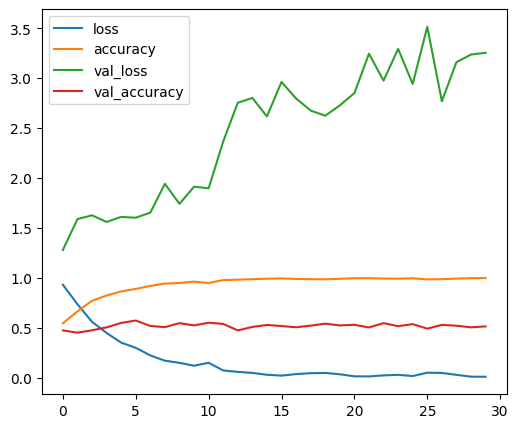

[[ 30 145 138]
 [ 12 291  11]
 [ 94  48 152]]


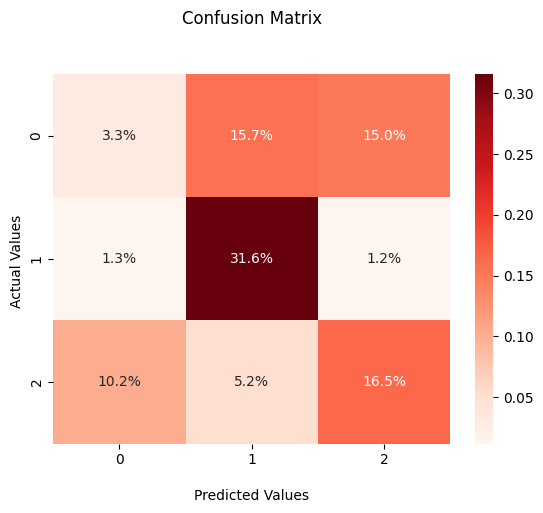

SUBJECT 1
8/8 [==============================] - 0s 8ms/step - loss: 5.5933 - accuracy: 0.1697
Score : loss of 5.593266487121582; accuracy of 16.970999538898468%
30/30 [==============================] - 0s 4ms/step
F1 score:  0.1746920253052549
Precision:  0.18534155955398937
Recall:  0.16970998925886144


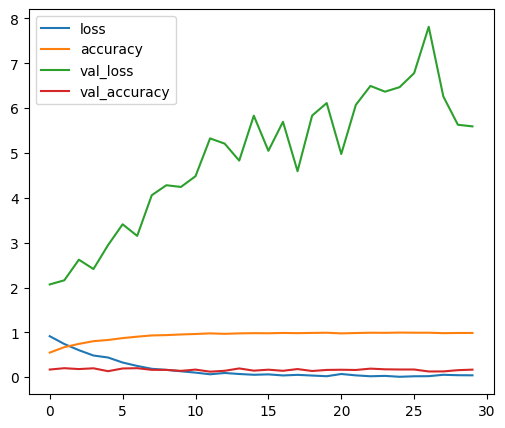

[[ 59  91 159]
 [ 67  57 194]
 [ 94 168  42]]


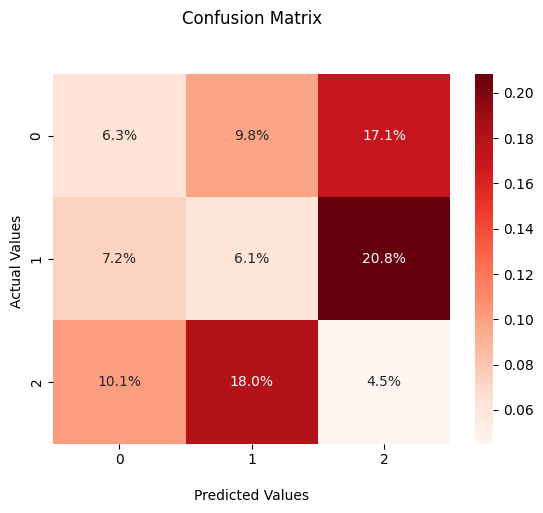

SUBJECT 2
8/8 [==============================] - 0s 9ms/step - loss: 5.6297 - accuracy: 0.2984
Score : loss of 5.629665851593018; accuracy of 29.83783781528473%
29/29 [==============================] - 0s 4ms/step
F1 score:  0.2709952483064699
Precision:  0.2762991465454845
Recall:  0.2983783783783784


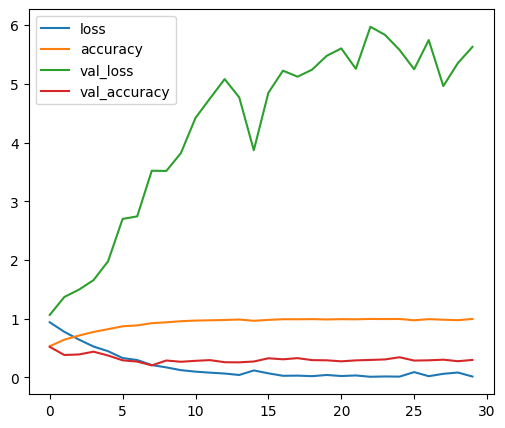

[[ 23 202  87]
 [ 97 176  38]
 [ 71 154  77]]


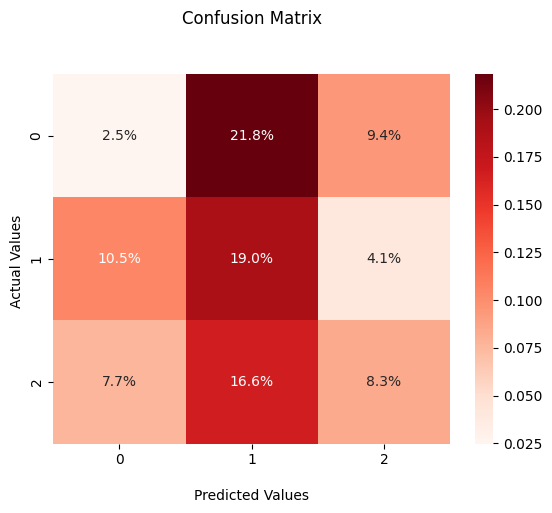

SUBJECT 3
8/8 [==============================] - 0s 8ms/step - loss: 4.8743 - accuracy: 0.4518
Score : loss of 4.874273777008057; accuracy of 45.178765058517456%
29/29 [==============================] - 0s 4ms/step
F1 score:  0.4224207379015475
Precision:  0.40241201432867557
Recall:  0.4517876489707476


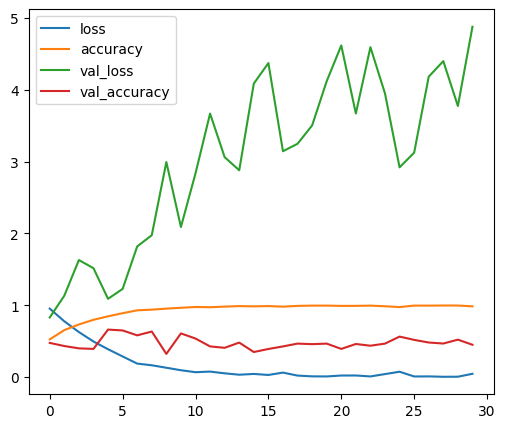

[[  0 280  16]
 [129 169  30]
 [ 35  16 248]]


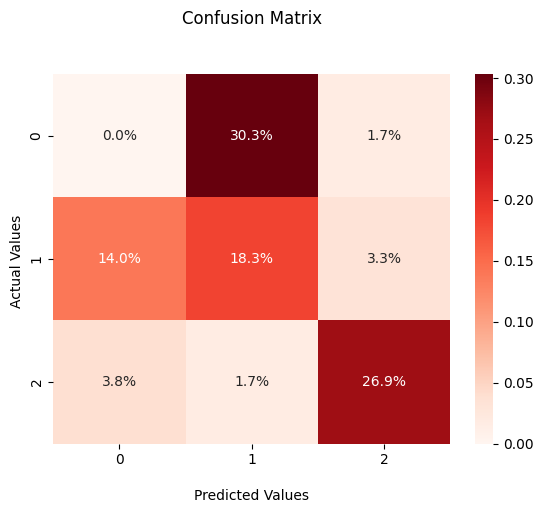

SUBJECT 4
8/8 [==============================] - 0s 8ms/step - loss: 10.4954 - accuracy: 0.0469
Score : loss of 10.495431900024414; accuracy of 4.694323241710663%
29/29 [==============================] - 0s 3ms/step
F1 score:  0.04856196355970485
Precision:  0.05029631940112289
Recall:  0.046943231441048026


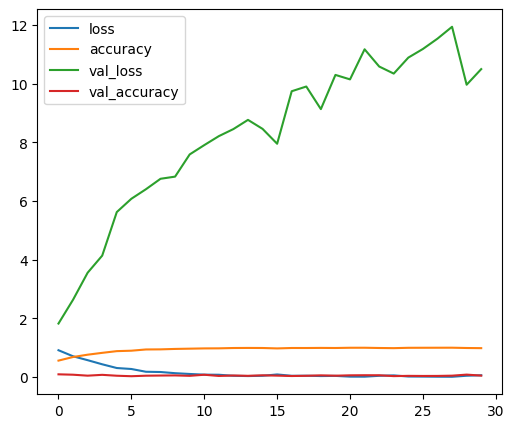

[[  0 109 188]
 [136  43 136]
 [162 142   0]]


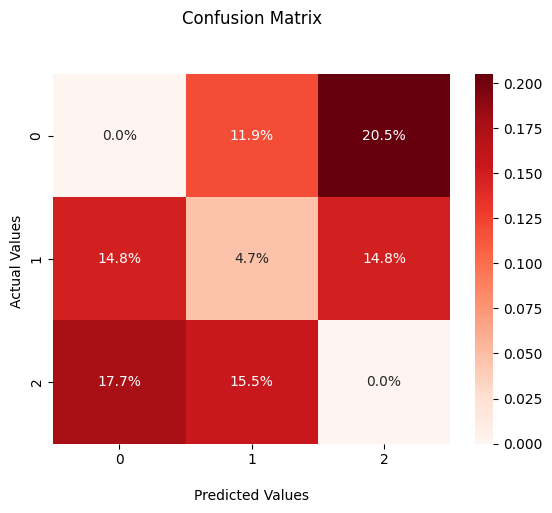

SUBJECT 5
8/8 [==============================] - 0s 8ms/step - loss: 8.6711 - accuracy: 0.1148
Score : loss of 8.671136856079102; accuracy of 11.47540956735611%
29/29 [==============================] - 0s 4ms/step
F1 score:  0.1490131536318279
Precision:  0.22701113788792396
Recall:  0.11475409836065574


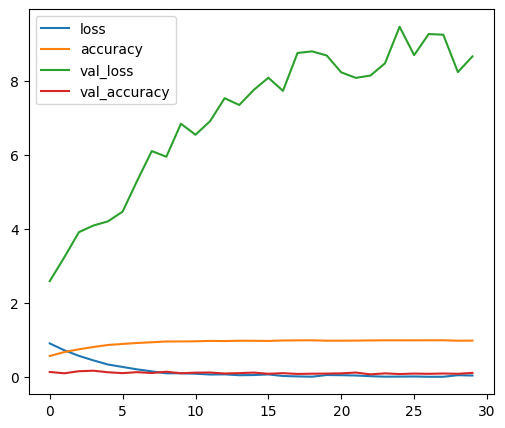

[[  0  13 287]
 [ 51  93 170]
 [249  40  12]]


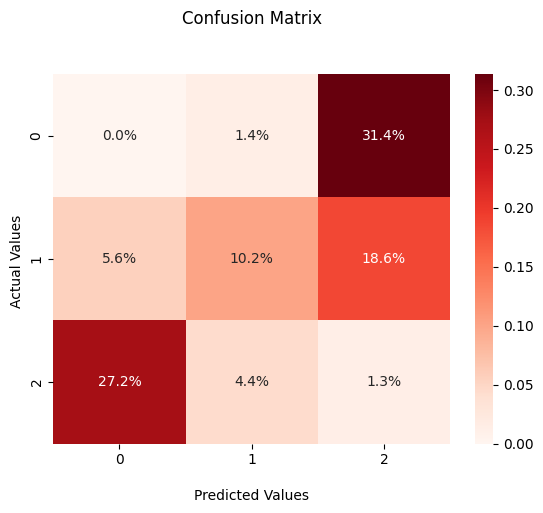

SUBJECT 6
8/8 [==============================] - 0s 9ms/step - loss: 6.7386 - accuracy: 0.3578
Score : loss of 6.738552570343018; accuracy of 35.77586114406586%
29/29 [==============================] - 1s 3ms/step
F1 score:  0.2885517110022914
Precision:  0.2545336169481938
Recall:  0.3577586206896552


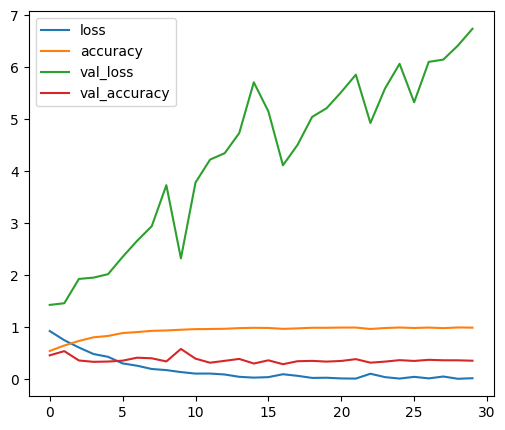

[[  0 209  98]
 [  0 237  78]
 [ 78 133  95]]


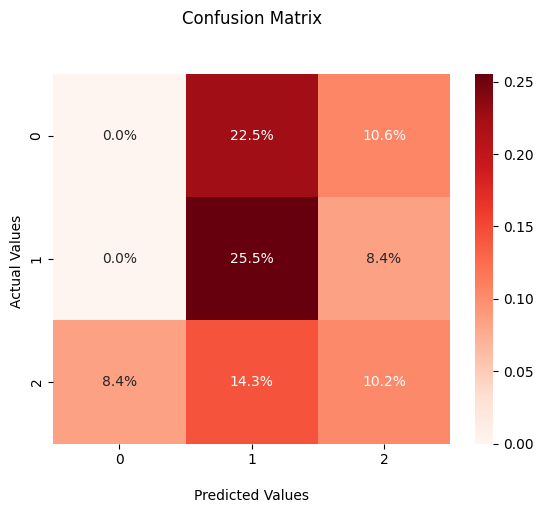

SUBJECT 7
8/8 [==============================] - 0s 8ms/step - loss: 2.8277 - accuracy: 0.5609
Score : loss of 2.827720880508423; accuracy of 56.0869574546814%
29/29 [==============================] - 0s 4ms/step
F1 score:  0.5600555445669626
Precision:  0.5597972917919962
Recall:  0.5608695652173913


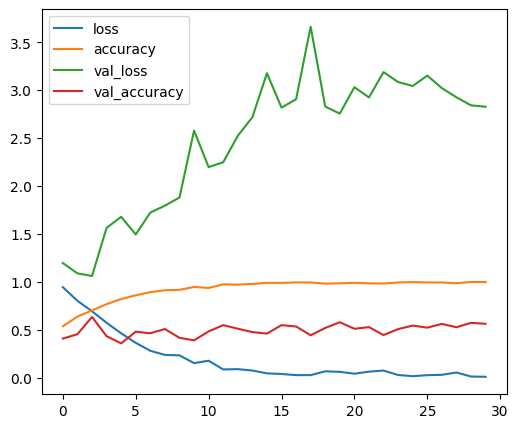

[[150  70  89]
 [ 97 177  39]
 [ 53  56 189]]


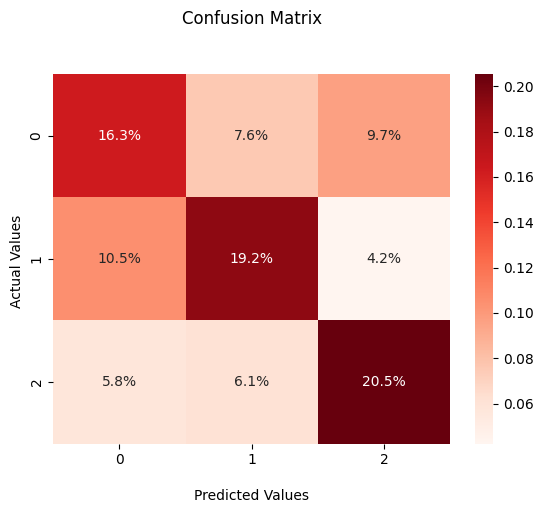

SUBJECT 8
8/8 [==============================] - 0s 8ms/step - loss: 3.7627 - accuracy: 0.4292
Score : loss of 3.7627081871032715; accuracy of 42.92084872722626%
29/29 [==============================] - 0s 4ms/step
F1 score:  0.43122383874763354
Precision:  0.43780720085067915
Recall:  0.42920847268673357


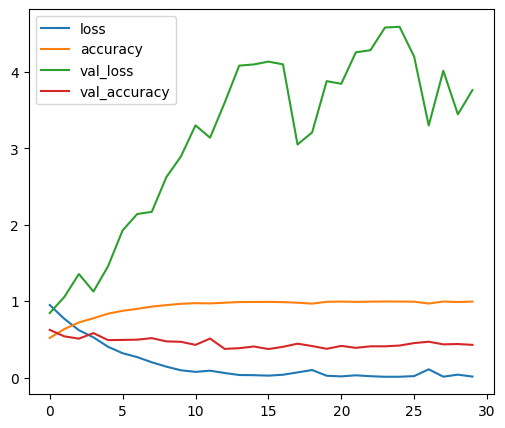

[[115  74 113]
 [111 133  65]
 [104  45 137]]


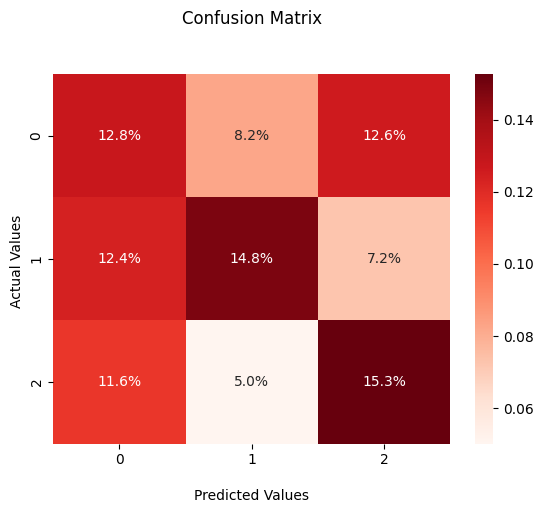

SUBJECT 9
8/8 [==============================] - 0s 8ms/step - loss: 2.7867 - accuracy: 0.5432
Score : loss of 2.786691904067993; accuracy of 54.3169379234314%
29/29 [==============================] - 0s 4ms/step
F1 score:  0.4788430640336932
Precision:  0.511367593221879
Recall:  0.5431693989071038


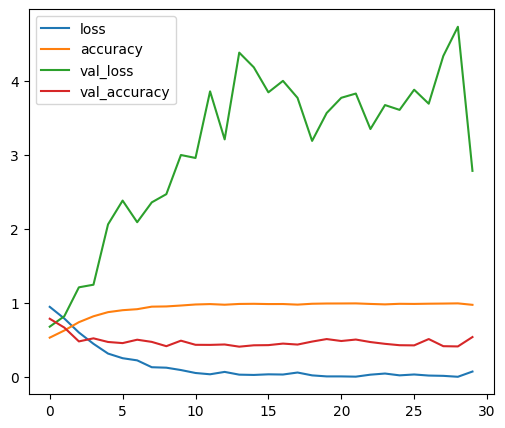

[[ 27 115 160]
 [ 36 245  37]
 [  0  70 225]]


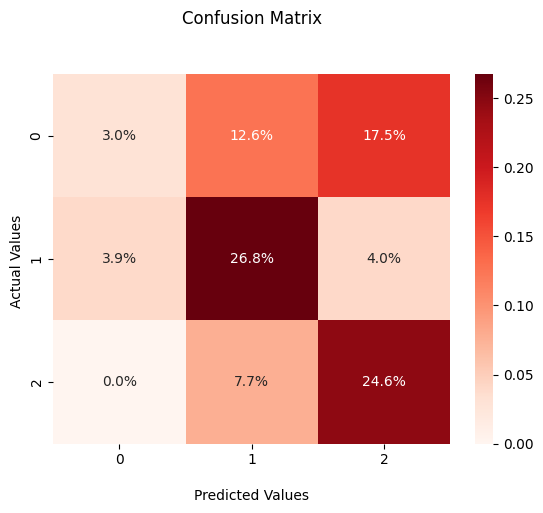

SUBJECT 10
8/8 [==============================] - 0s 9ms/step - loss: 3.1279 - accuracy: 0.6694
Score : loss of 3.1279494762420654; accuracy of 66.94473624229431%
30/30 [==============================] - 1s 4ms/step
F1 score:  0.6441621627007612
Precision:  0.6676768293327385
Recall:  0.6694473409801877


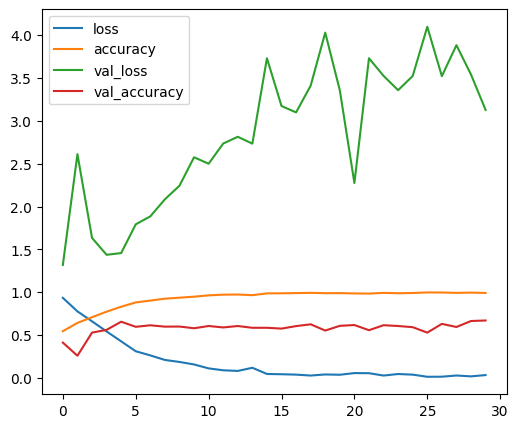

[[ 93 215  14]
 [ 62 241  23]
 [  2   1 308]]


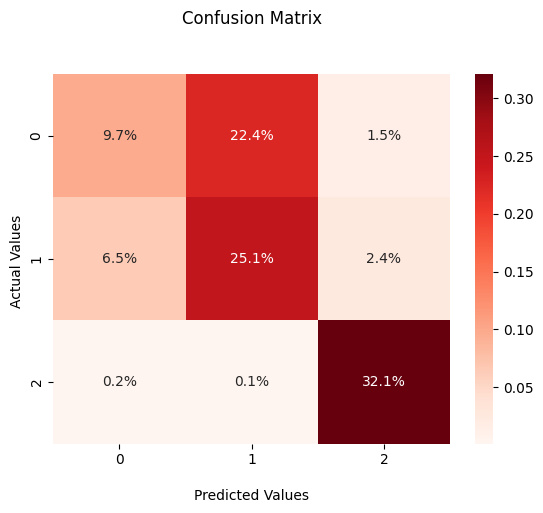

SUBJECT 11
8/8 [==============================] - 0s 9ms/step - loss: 5.4018 - accuracy: 0.2714
Score : loss of 5.401848793029785; accuracy of 27.144408226013184%
29/29 [==============================] - 0s 4ms/step
F1 score:  0.26637978434011333
Precision:  0.2619513126915202
Recall:  0.2714440825190011


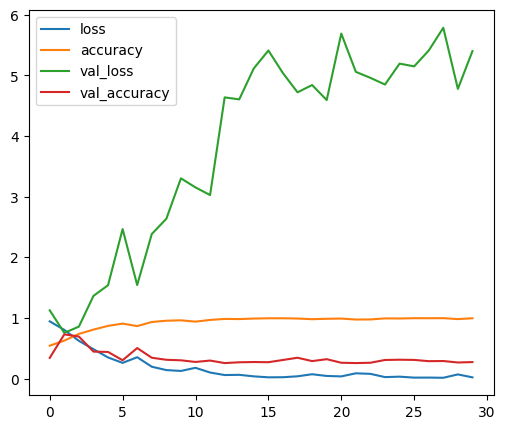

[[ 30 222  47]
 [200  34  87]
 [ 36  79 186]]


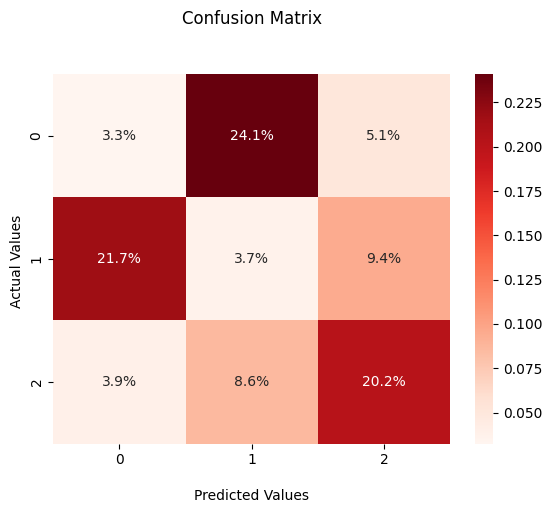

SUBJECT 12
8/8 [==============================] - 0s 9ms/step - loss: 4.3866 - accuracy: 0.3678
Score : loss of 4.386624813079834; accuracy of 36.78414225578308%
29/29 [==============================] - 0s 3ms/step
F1 score:  0.3107776952433304
Precision:  0.3162462435590189
Recall:  0.36784140969163


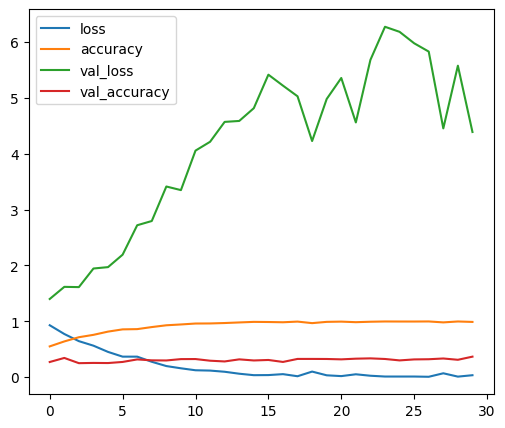

[[ 16  55 221]
 [103  74 129]
 [ 13  53 244]]


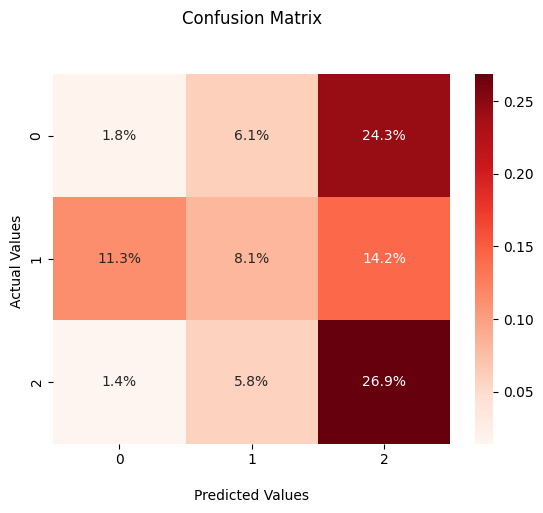

SUBJECT 13
8/8 [==============================] - 0s 11ms/step - loss: 3.2814 - accuracy: 0.4760
Score : loss of 3.2814083099365234; accuracy of 47.603484988212585%
29/29 [==============================] - 1s 4ms/step
F1 score:  0.4888319179418251
Precision:  0.5112906339203934
Recall:  0.4760348583877996


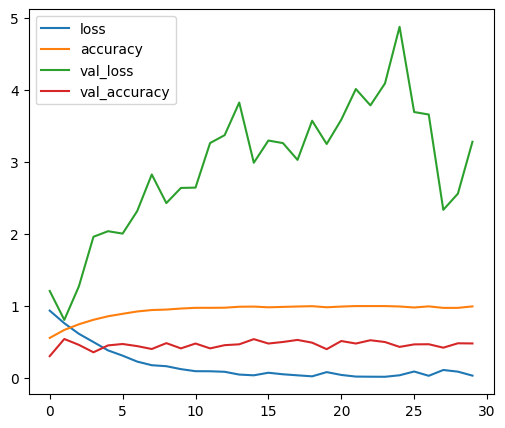

[[110 189   0]
 [151 135  37]
 [ 48  56 192]]


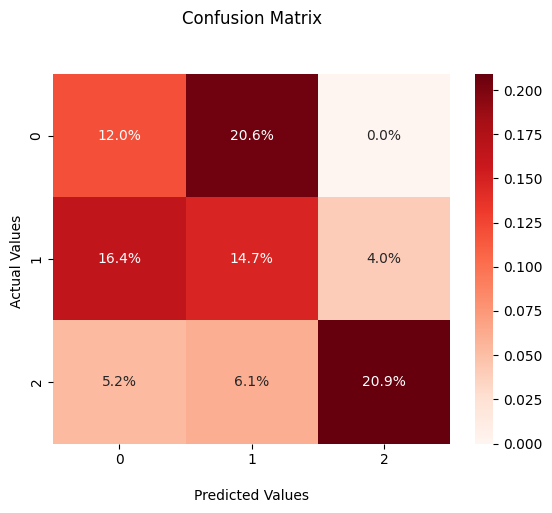

SUBJECT 14
8/8 [==============================] - 0s 10ms/step - loss: 5.4503 - accuracy: 0.2965
Score : loss of 5.450303077697754; accuracy of 29.64930832386017%
30/30 [==============================] - 1s 4ms/step
F1 score:  0.2955801159196101
Precision:  0.2969161546371066
Recall:  0.2964930924548353


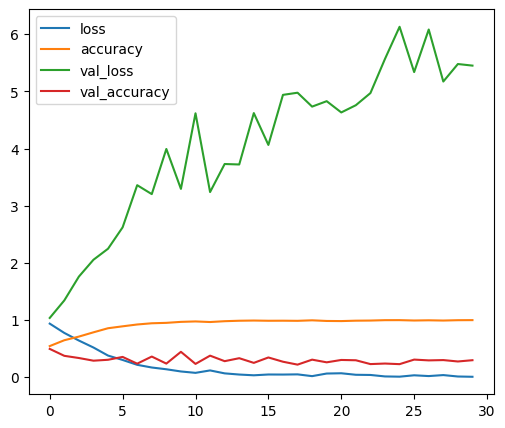

[[ 71  91 139]
 [ 71 119 130]
 [106 125  89]]


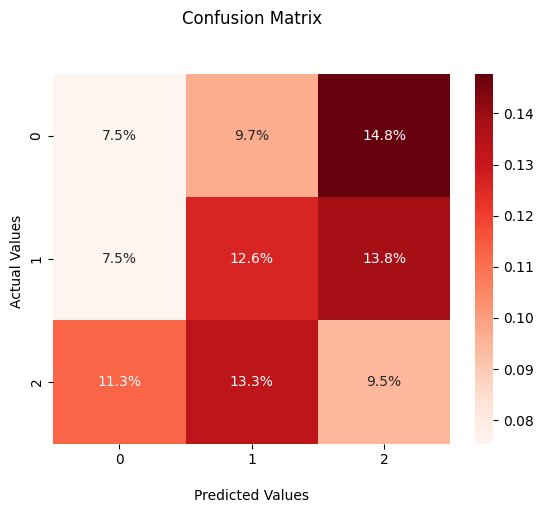

SUBJECT 15
8/8 [==============================] - 0s 9ms/step - loss: 6.6169 - accuracy: 0.1870
Score : loss of 6.616853713989258; accuracy of 18.70187073945999%
29/29 [==============================] - 1s 5ms/step
F1 score:  0.17737007703427804
Precision:  0.17290211762420887
Recall:  0.18701870187018702


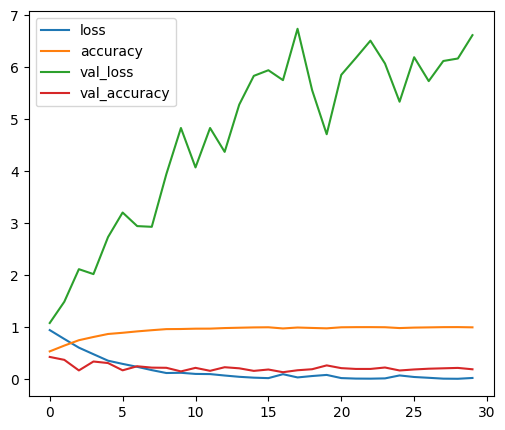

[[ 92 221   0]
 [ 63  59 177]
 [250  28  19]]


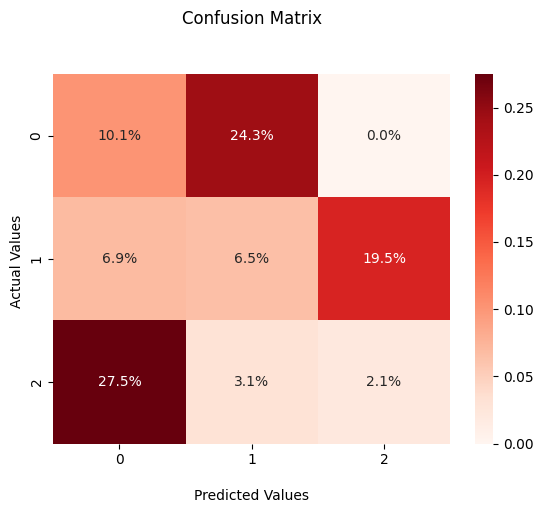

SUBJECT 16
8/8 [==============================] - 0s 9ms/step - loss: 6.6692 - accuracy: 0.1401
Score : loss of 6.669215202331543; accuracy of 14.008620381355286%
29/29 [==============================] - 0s 4ms/step
F1 score:  0.12929911997126436
Precision:  0.12538281689329292
Recall:  0.1400862068965517


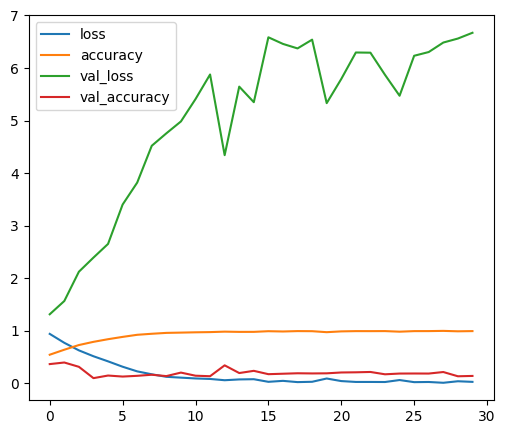

[[ 90 155  72]
 [ 97  19 196]
 [252  26  21]]


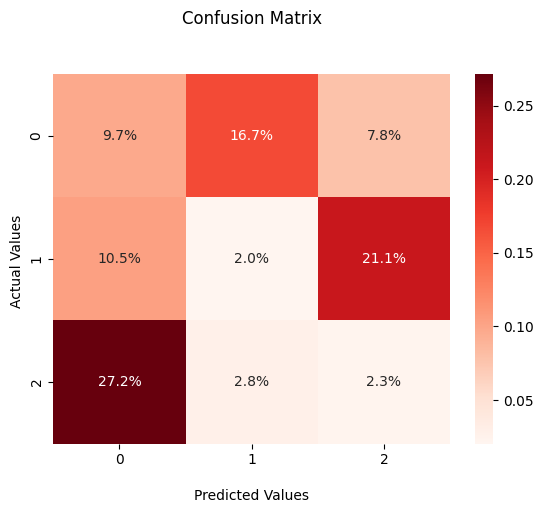

SUBJECT 17
8/8 [==============================] - 0s 9ms/step - loss: 3.7277 - accuracy: 0.3775
Score : loss of 3.7276883125305176; accuracy of 37.754011154174805%
30/30 [==============================] - 1s 4ms/step
F1 score:  0.38082103133052114
Precision:  0.40016806957034656
Recall:  0.3775401069518717


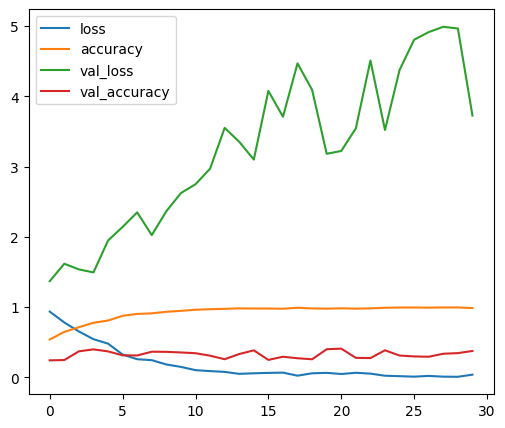

[[141 155  27]
 [ 37 134 138]
 [ 70 155  78]]


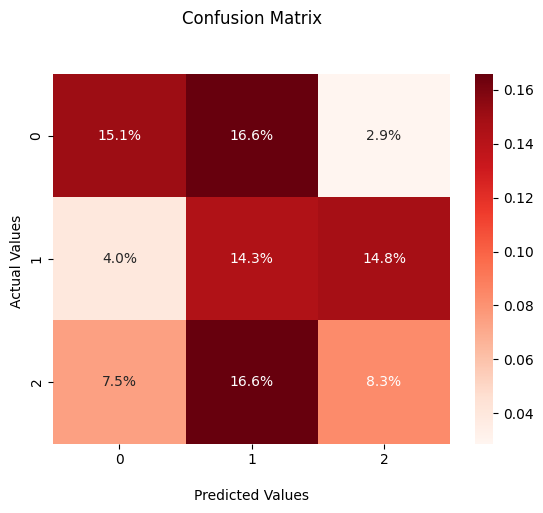

SUBJECT 18
8/8 [==============================] - 0s 9ms/step - loss: 6.4545 - accuracy: 0.2740
Score : loss of 6.454543590545654; accuracy of 27.400216460227966%
29/29 [==============================] - 0s 4ms/step
F1 score:  0.26281903395256245
Precision:  0.25290523643039303
Recall:  0.2740021574973031


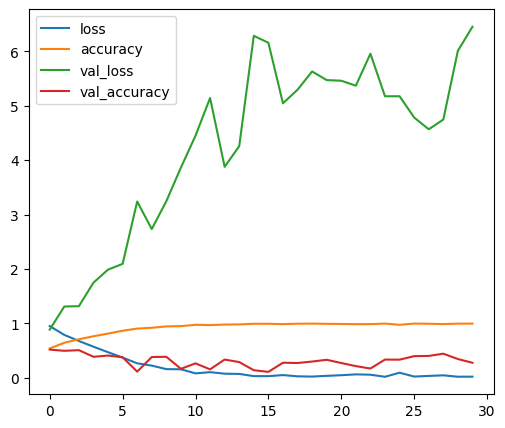

[[ 46 254  18]
 [189  10 113]
 [ 98   1 198]]


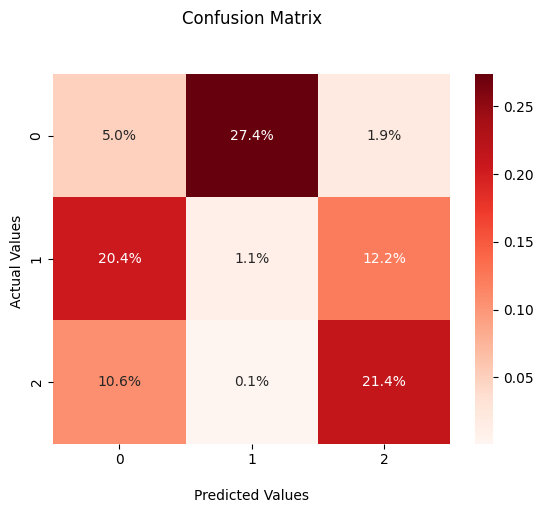

SUBJECT 19
8/8 [==============================] - 0s 9ms/step - loss: 4.2914 - accuracy: 0.5033
Score : loss of 4.291444778442383; accuracy of 50.33186078071594%
29/29 [==============================] - 0s 4ms/step
F1 score:  0.5068103588234824
Precision:  0.5291223266700794
Recall:  0.5033185840707964


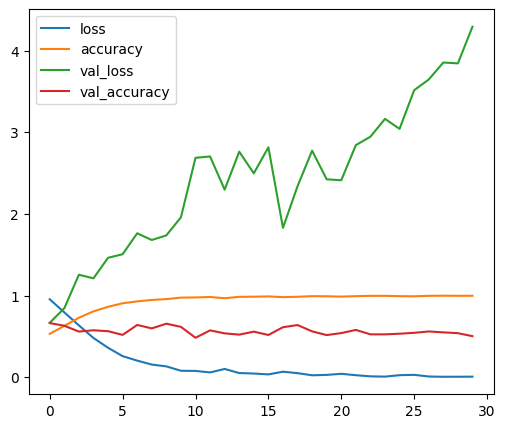

[[ 87 218   2]
 [120 145  39]
 [  0  70 223]]


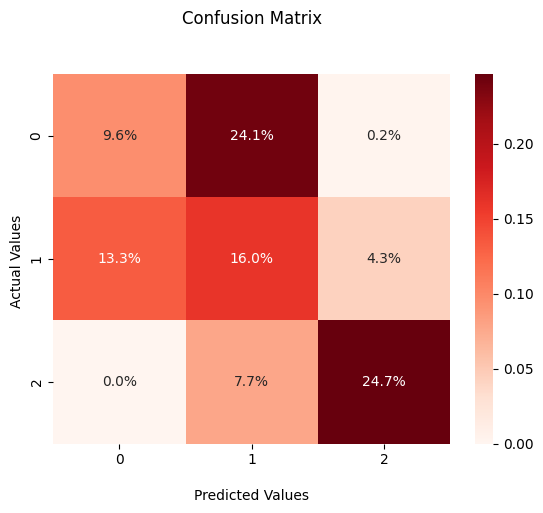

SUBJECT 20
8/8 [==============================] - 0s 10ms/step - loss: 6.3949 - accuracy: 0.2267
Score : loss of 6.394936561584473; accuracy of 22.668112814426422%
29/29 [==============================] - 1s 4ms/step
F1 score:  0.2176178655966948
Precision:  0.21636688276239974
Recall:  0.22668112798264642


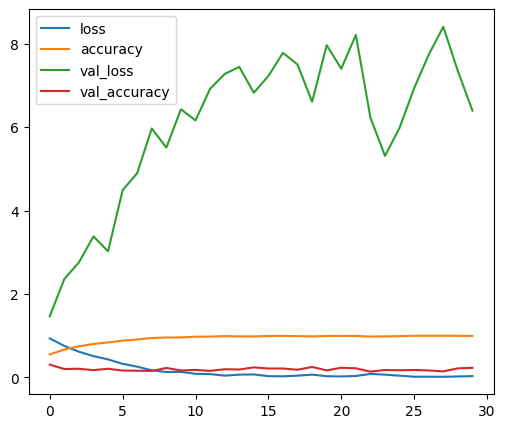

[[117 191   8]
 [121  16 163]
 [194  36  76]]


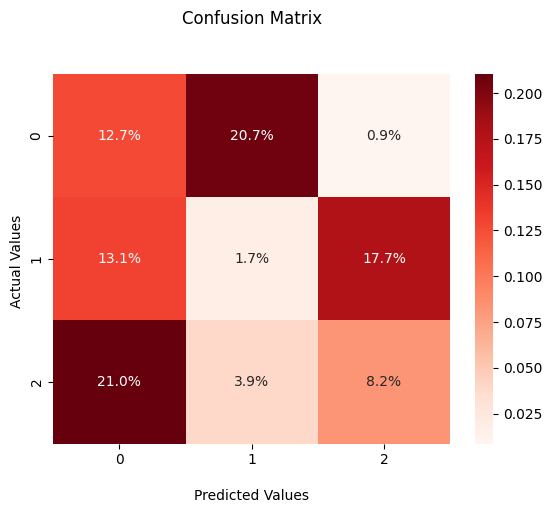

SUBJECT 21
8/8 [==============================] - 0s 8ms/step - loss: 4.5002 - accuracy: 0.3991
Score : loss of 4.500227928161621; accuracy of 39.911797642707825%
29/29 [==============================] - 0s 4ms/step
F1 score:  0.39843143806002274
Precision:  0.41402763929686187
Recall:  0.39911797133406834


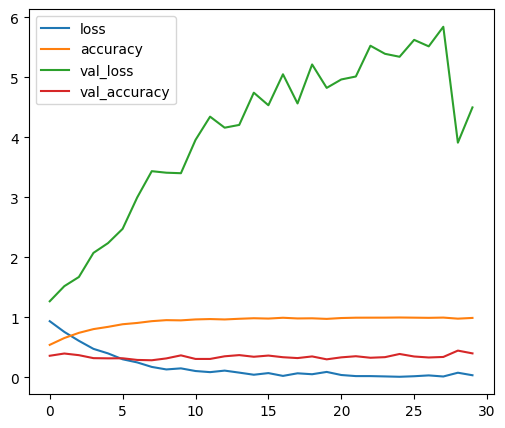

[[109  32 168]
 [ 84 107 111]
 [ 53  97 146]]


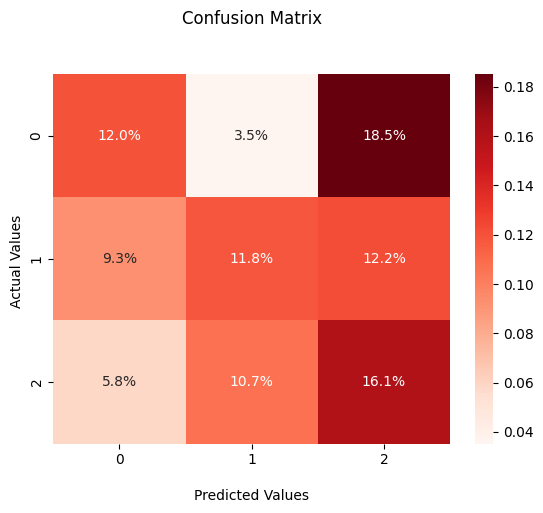

In [ ]:
for sub in range(len(all_data)):

    print("SUBJECT",sub)

    train_data = {}
    
    train_data["data"] = np.concatenate([all_data[i]["data"] for i in range(len(all_data)) if i != sub])    
    
    train_data["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])
    
    test_data = all_data[sub]
    cm_w_o_ft, acc_w_o_ft, loss_w_o_ft, f1_w_o_ft, prec_w_o_ft, rec_w_o_ft = lstm(train_data, test_data)

#**Average accuracy and F1 score (no ft)**

In [3]:
print(acc_w_o_ft)

[51.357221603393555, 16.970999538898468, 29.83783781528473, 45.178765058517456, 4.694323241710663, 11.47540956735611, 35.77586114406586, 56.0869574546814, 42.92084872722626, 54.3169379234314, 66.94473624229431, 27.144408226013184, 36.78414225578308, 47.603484988212585, 29.64930832386017, 18.70187073945999, 14.008620381355286, 37.754011154174805, 27.400216460227966, 50.33186078071594, 22.668112814426422, 39.911797642707825]


In [4]:
print(np.mean(acc_w_o_ft))
print(np.mean(f1_w_o_ft))

35.86752225052226
0.3444176927541321


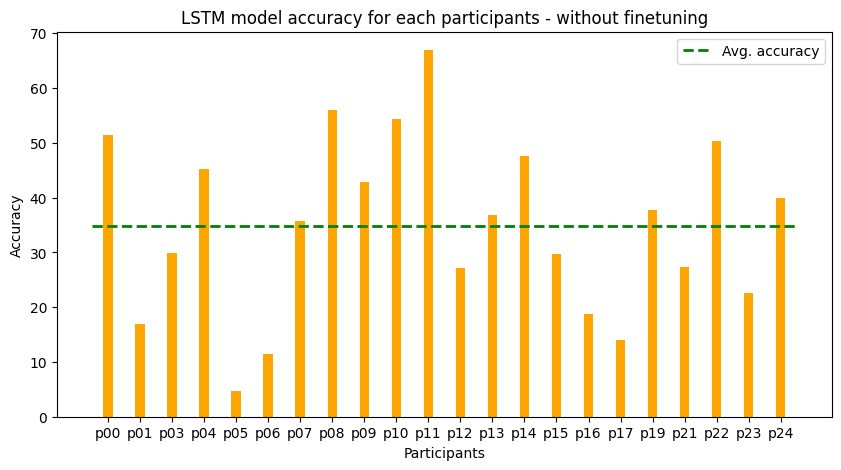

In [7]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_o_ft, color ='orange',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("LSTM model accuracy for each participants - without finetuning")

plt.hlines(y=(np.mean(acc_w_o_ft)), xmin=-0.5, xmax=(len(acc_w_o_ft)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

[[[30, 145, 138], [12, 291, 11], [94, 48, 152]], [[59, 91, 159], [67, 57, 194], [94, 168, 42]], [[23, 202, 87], [97, 176, 38], [71, 154, 77]], [[0, 280, 16], [129, 169, 30], [35, 16, 248]], [[0, 109, 188], [136, 43, 136], [162, 142, 0]], [[0, 13, 287], [51, 93, 170], [249, 40, 12]], [[0, 209, 98], [0, 237, 78], [78, 133, 95]], [[150, 70, 89], [97, 177, 39], [53, 56, 189]], [[115, 74, 113], [111, 133, 65], [104, 45, 137]], [[27, 115, 160], [36, 245, 37], [0, 70, 225]], [[93, 215, 14], [62, 241, 23], [2, 1, 308]], [[30, 222, 47], [200, 34, 87], [36, 79, 186]], [[16, 55, 221], [103, 74, 129], [13, 53, 244]], [[110, 189, 0], [151, 135, 37], [48, 56, 192]], [[71, 91, 139], [71, 119, 130], [106, 125, 89]], [[92, 221, 0], [63, 59, 177], [250, 28, 19]], [[90, 155, 72], [97, 19, 196], [252, 26, 21]], [[141, 155, 27], [37, 134, 138], [70, 155, 78]], [[46, 254, 18], [189, 10, 113], [98, 1, 198]], [[87, 218, 2], [120, 145, 39], [0, 70, 223]], [[117, 191, 8], [121, 16, 163], [194, 36, 76]], [[109, 

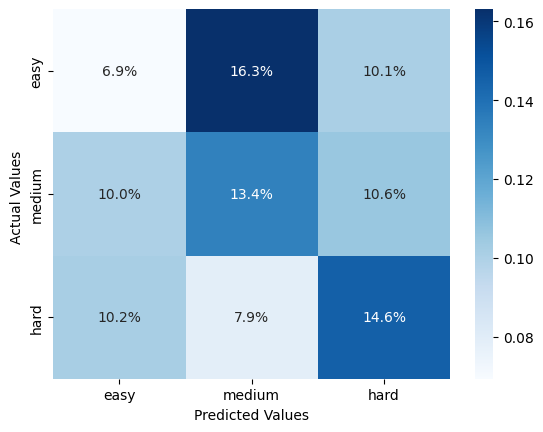

In [3]:
# cm_w_o_ft seperated by commas

print(cm_w_o_ft)

ele_00, ele_01, ele_02 = [], [], []
ele_10, ele_11, ele_12 = [], [], []
ele_20, ele_21, ele_22 = [], [], []

for i in range(len(cm_w_o_ft)):
  ele_00.append(cm_w_o_ft[i][0][0])
  ele_01.append(cm_w_o_ft[i][0][1])
  ele_02.append(cm_w_o_ft[i][0][2])
  ele_10.append(cm_w_o_ft[i][1][0])
  ele_11.append(cm_w_o_ft[i][1][1])
  ele_12.append(cm_w_o_ft[i][1][2])
  ele_20.append(cm_w_o_ft[i][2][0])
  ele_21.append(cm_w_o_ft[i][2][1])
  ele_22.append(cm_w_o_ft[i][2][2])


cm = [[ np.mean(ele_00), np.mean(ele_01), np.mean(ele_02)],
      [ np.mean(ele_10), np.mean(ele_11), np.mean(ele_12)],
      [ np.mean(ele_20), np.mean(ele_21), np.mean(ele_22)]]

print(cm)

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues')
ax.figsize=(5,5)
#ax.set_title('\nConfusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');
    
ax.xaxis.set_ticklabels(['easy','medium','hard'])
ax.yaxis.set_ticklabels(['easy','medium','hard'])

#plt.savefig('lstm_cm_wo.pdf')

plt.show()

#**Finetuning 5% of test data (LOSO)**

SUBJECT 0
7/7 [==============================] - 0s 13ms/step - loss: 1.2066 - accuracy: 0.7414
Score : loss of 1.206626057624817; accuracy of 74.14187788963318%
28/28 [==============================] - 1s 4ms/step
F1 score:  0.7376457387329195
Precision:  0.7365062065357626
Recall:  0.7414187643020596


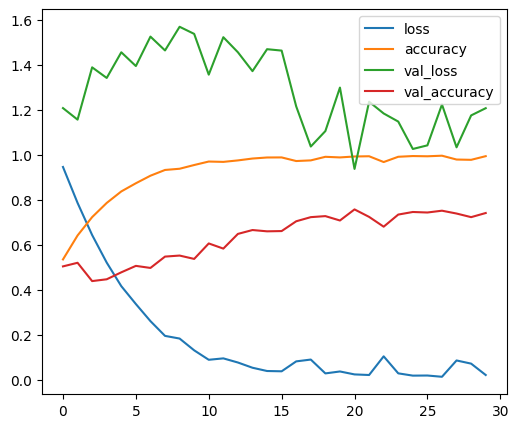

[[173  81  42]
 [ 69 225   6]
 [ 19   9 250]]


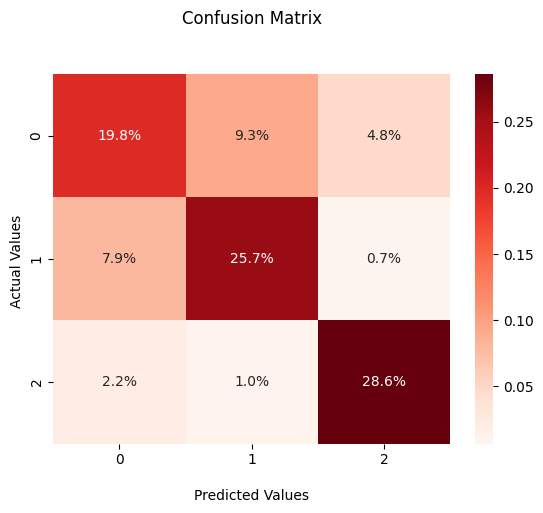

SUBJECT 1
7/7 [==============================] - 0s 8ms/step - loss: 3.6798 - accuracy: 0.2783
Score : loss of 3.6797590255737305; accuracy of 27.82805562019348%
28/28 [==============================] - 0s 4ms/step
F1 score:  0.28743084421773135
Precision:  0.29925828455516146
Recall:  0.27828054298642535


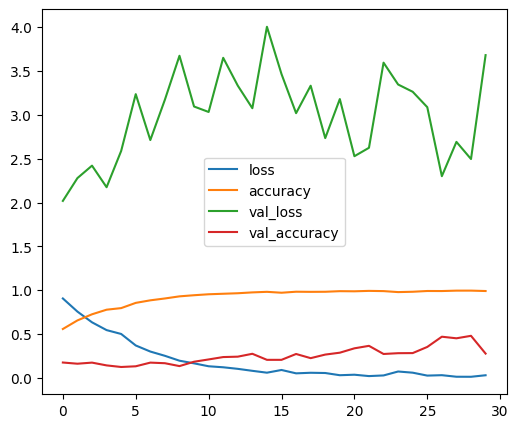

[[132  31 131]
 [ 47  73 182]
 [ 80 167  41]]


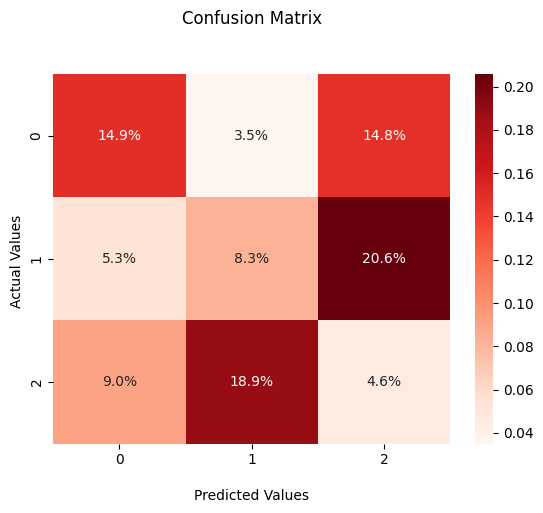

SUBJECT 2
7/7 [==============================] - 0s 8ms/step - loss: 0.9936 - accuracy: 0.7472
Score : loss of 0.9936124682426453; accuracy of 74.71526265144348%
28/28 [==============================] - 0s 4ms/step
F1 score:  0.745331351011079
Precision:  0.7744951371788361
Recall:  0.7471526195899773


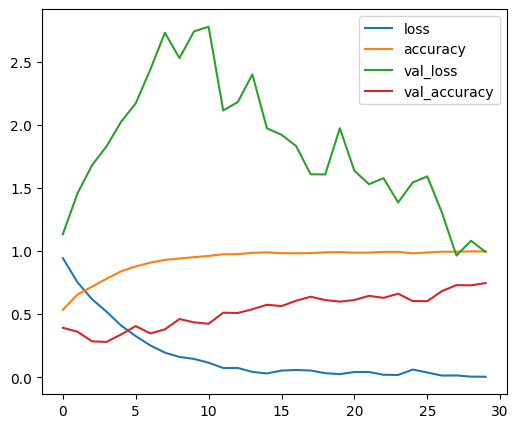

[[194  33  71]
 [  7 271  13]
 [  5  93 191]]


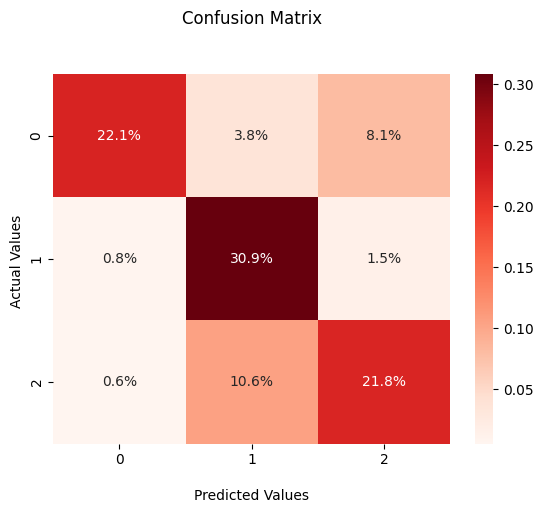

SUBJECT 3
7/7 [==============================] - 0s 8ms/step - loss: 1.1253 - accuracy: 0.7420
Score : loss of 1.1253374814987183; accuracy of 74.20091032981873%
28/28 [==============================] - 0s 4ms/step
F1 score:  0.7322764790723133
Precision:  0.7682691791113267
Recall:  0.7420091324200914


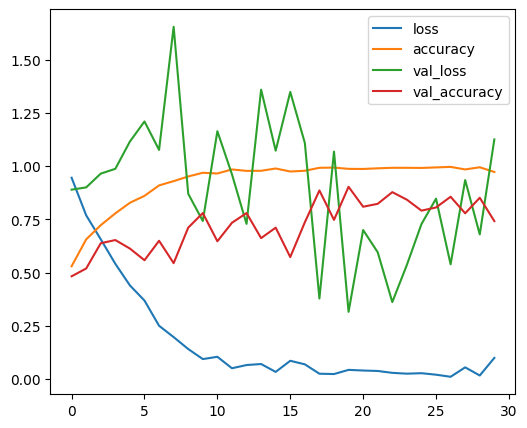

[[127 156   0]
 [ 30 251  26]
 [  0  14 272]]


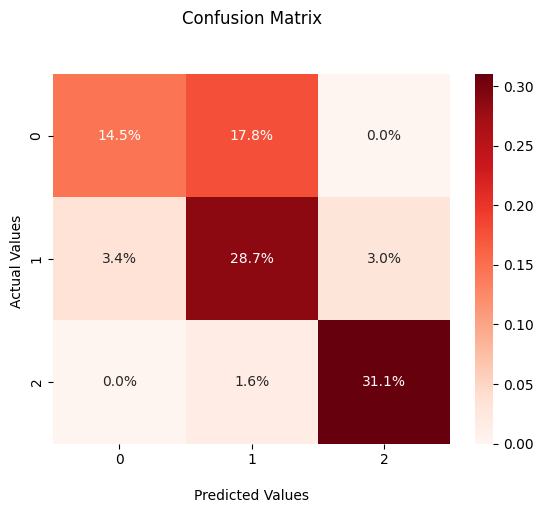

SUBJECT 4
7/7 [==============================] - 0s 9ms/step - loss: 3.7361 - accuracy: 0.3517
Score : loss of 3.7360520362854004; accuracy of 35.172414779663086%
28/28 [==============================] - 0s 4ms/step
F1 score:  0.34902811145145807
Precision:  0.3490000455932119
Recall:  0.35172413793103446


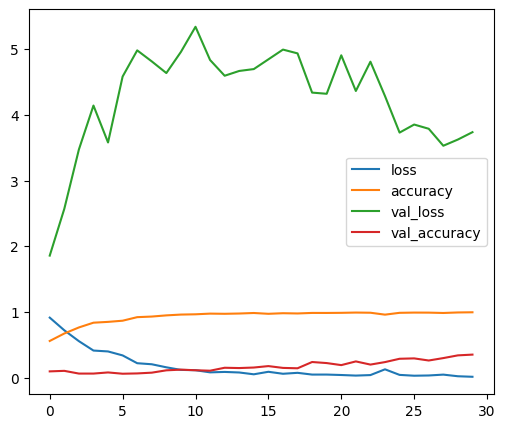

[[ 92 107  82]
 [ 78 132  90]
 [ 96 111  82]]


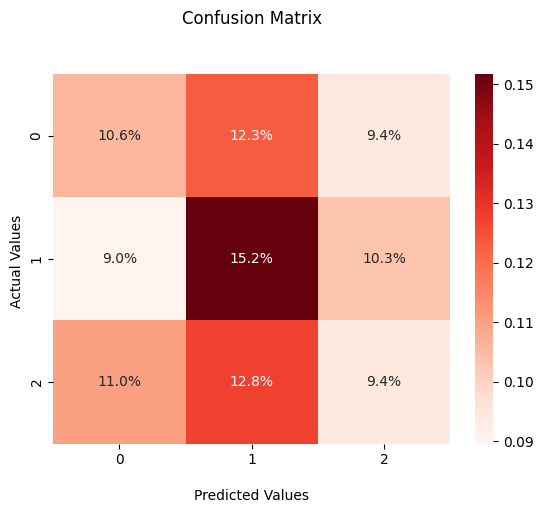

SUBJECT 5
7/7 [==============================] - 0s 8ms/step - loss: 1.3620 - accuracy: 0.7503
Score : loss of 1.3619884252548218; accuracy of 75.02877116203308%
28/28 [==============================] - 0s 4ms/step
F1 score:  0.7512096398364694
Precision:  0.7530762032203262
Recall:  0.7502876869965478


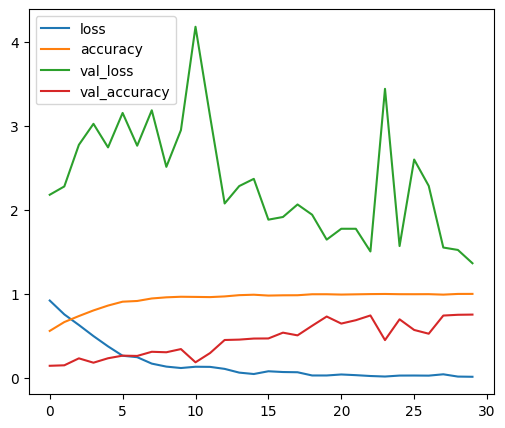

[[216  25  39]
 [ 15 228  60]
 [ 37  41 208]]


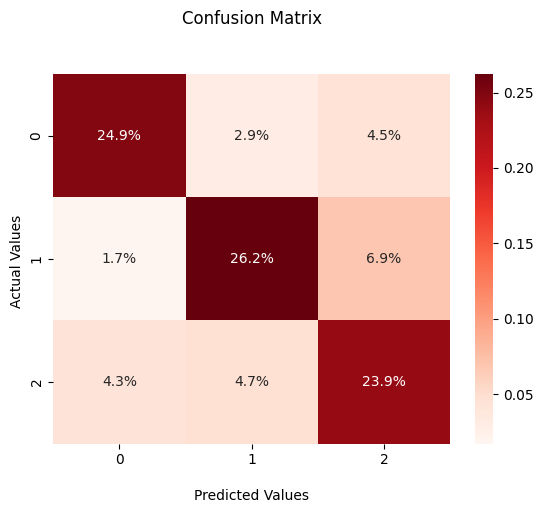

SUBJECT 6
7/7 [==============================] - 0s 9ms/step - loss: 1.5027 - accuracy: 0.7072
Score : loss of 1.502742886543274; accuracy of 70.7150936126709%
28/28 [==============================] - 0s 4ms/step
F1 score:  0.6939943730295912
Precision:  0.6984959575293642
Recall:  0.7071509648127128


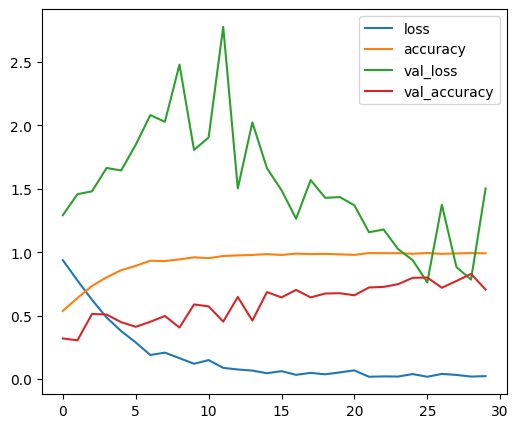

[[236  18  42]
 [  5 261  30]
 [108  55 126]]


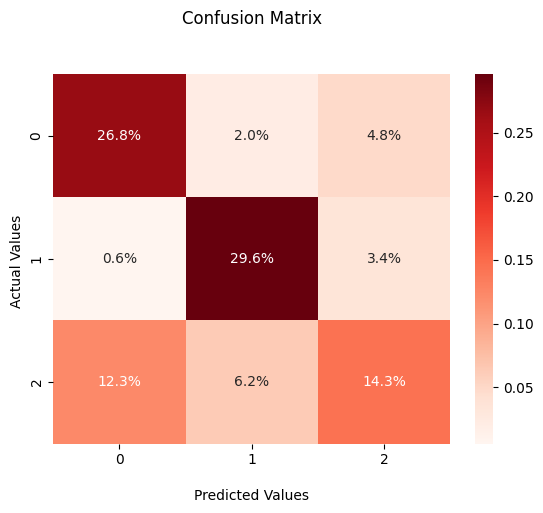

SUBJECT 7
7/7 [==============================] - 0s 9ms/step - loss: 1.7654 - accuracy: 0.7277
Score : loss of 1.7654482126235962; accuracy of 72.76887893676758%
28/28 [==============================] - 0s 4ms/step
F1 score:  0.7249215626925675
Precision:  0.7475630199550929
Recall:  0.7276887871853547


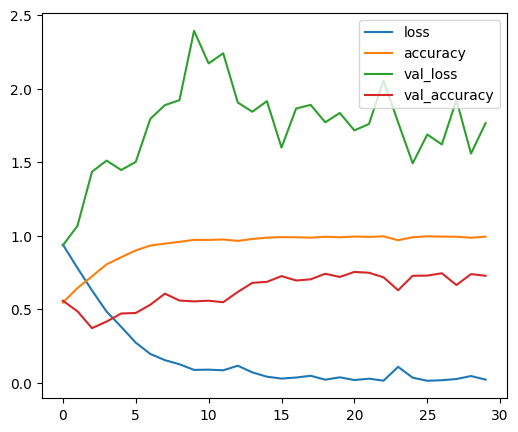

[[175  43  82]
 [ 30 220  41]
 [  0  42 241]]


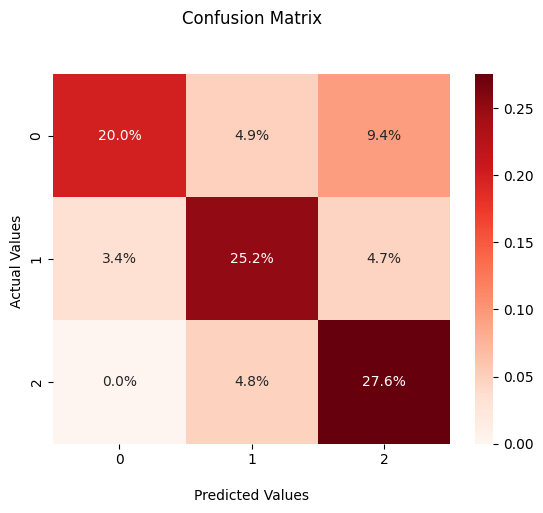

SUBJECT 8
7/7 [==============================] - 0s 11ms/step - loss: 1.9451 - accuracy: 0.6420
Score : loss of 1.9451037645339966; accuracy of 64.20187950134277%
27/27 [==============================] - 1s 5ms/step
F1 score:  0.6353501494292282
Precision:  0.6488974362184289
Recall:  0.642018779342723


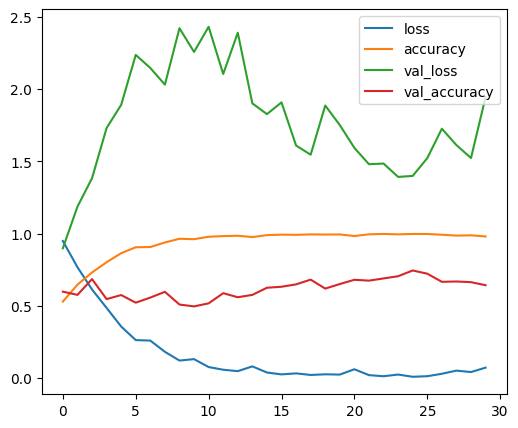

[[132  75  79]
 [ 12 226  55]
 [ 48  36 189]]


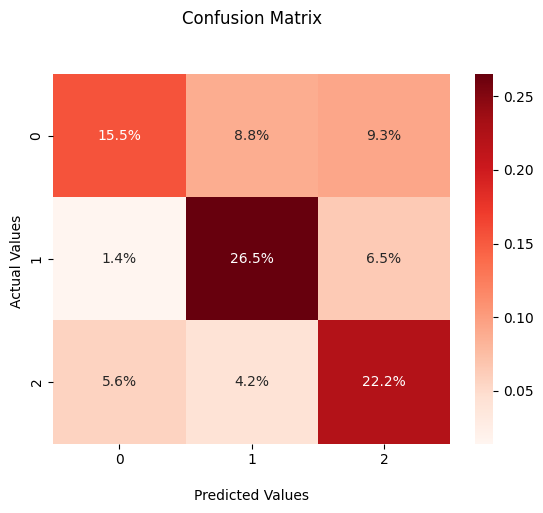

SUBJECT 9
7/7 [==============================] - 0s 9ms/step - loss: 1.4727 - accuracy: 0.7445
Score : loss of 1.472720742225647; accuracy of 74.45339560508728%
28/28 [==============================] - 0s 4ms/step
F1 score:  0.7386110094579841
Precision:  0.7840296373792767
Recall:  0.7445339470655926


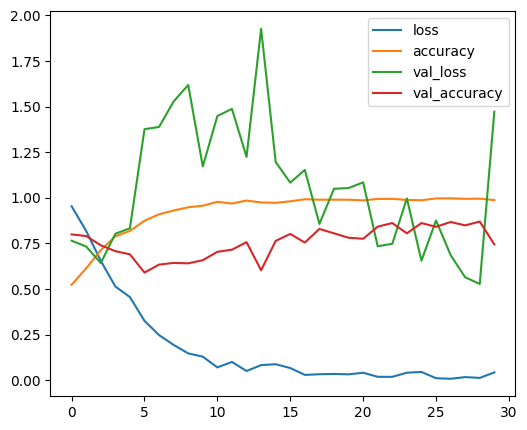

[[201  79   7]
 [  6 294   7]
 [ 44  79 152]]


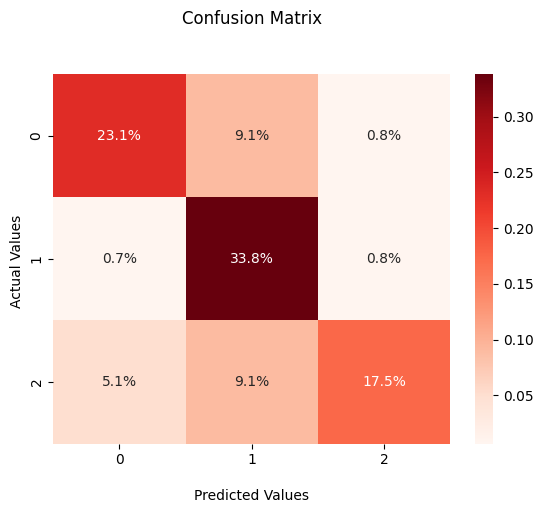

SUBJECT 10
8/8 [==============================] - 0s 9ms/step - loss: 0.7325 - accuracy: 0.8814
Score : loss of 0.732488751411438; accuracy of 88.14489841461182%
29/29 [==============================] - 1s 4ms/step
F1 score:  0.8804656623963417
Precision:  0.8834803700764724
Recall:  0.8814489571899012


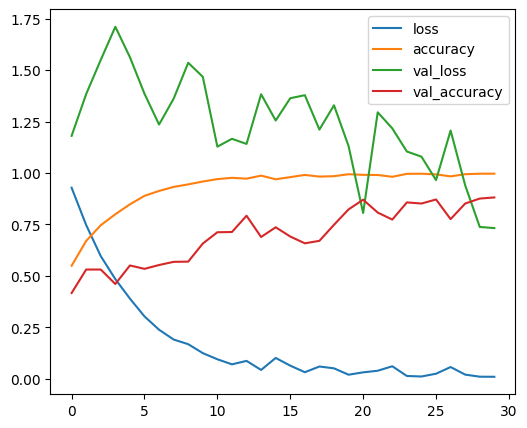

[[246  53  11]
 [ 10 274  20]
 [ 14   0 283]]


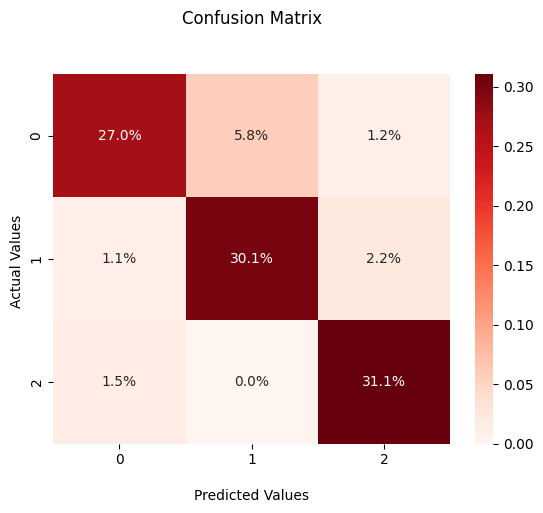

SUBJECT 11
7/7 [==============================] - 0s 9ms/step - loss: 1.2148 - accuracy: 0.7140
Score : loss of 1.2147892713546753; accuracy of 71.39587998390198%
28/28 [==============================] - 0s 4ms/step
F1 score:  0.7094004293478934
Precision:  0.7261836495243029
Recall:  0.7139588100686499


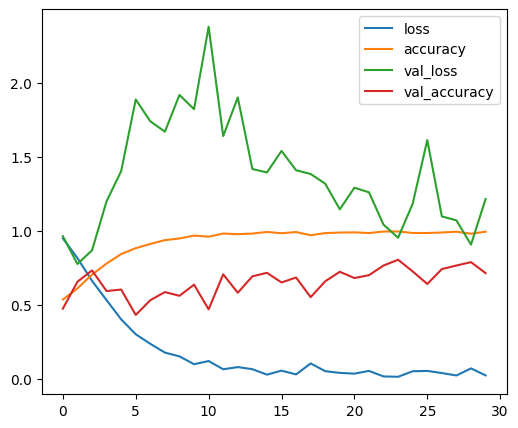

[[254  19  10]
 [ 86 179  41]
 [ 48  46 191]]


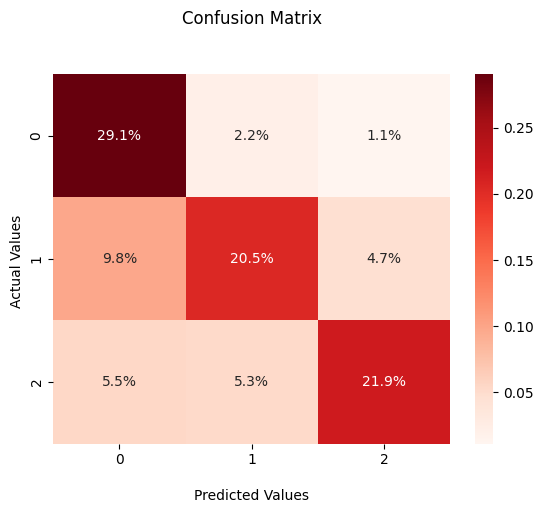

SUBJECT 12
7/7 [==============================] - 0s 8ms/step - loss: 0.5984 - accuracy: 0.8828
Score : loss of 0.5983536243438721; accuracy of 88.28306198120117%
27/27 [==============================] - 0s 4ms/step
F1 score:  0.8820275293304471
Precision:  0.888439970627745
Recall:  0.882830626450116


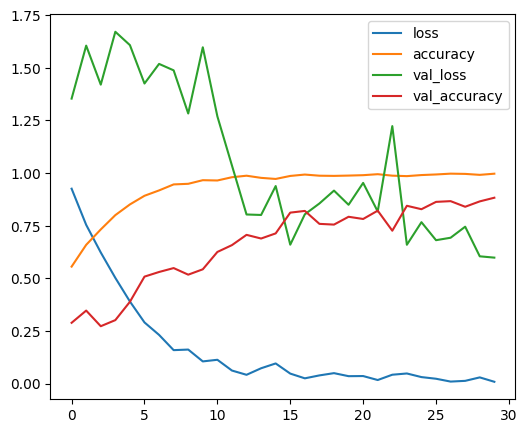

[[211  47  15]
 [ 14 268   9]
 [  1  15 282]]


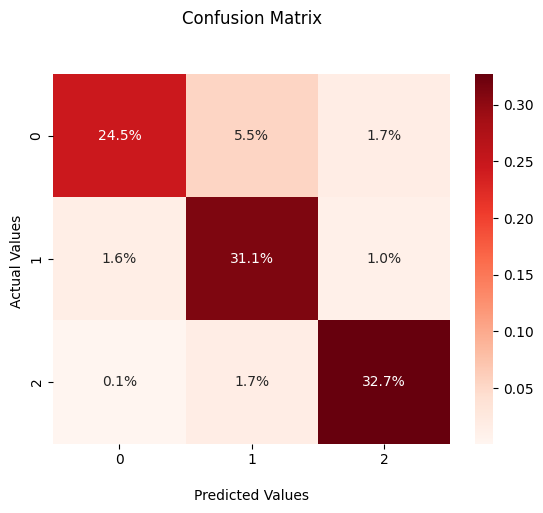

SUBJECT 13
7/7 [==============================] - 0s 8ms/step - loss: 1.3295 - accuracy: 0.7947
Score : loss of 1.3294557332992554; accuracy of 79.47247624397278%
28/28 [==============================] - 0s 4ms/step
F1 score:  0.7982934516270169
Precision:  0.8185814125579505
Recall:  0.7947247706422018


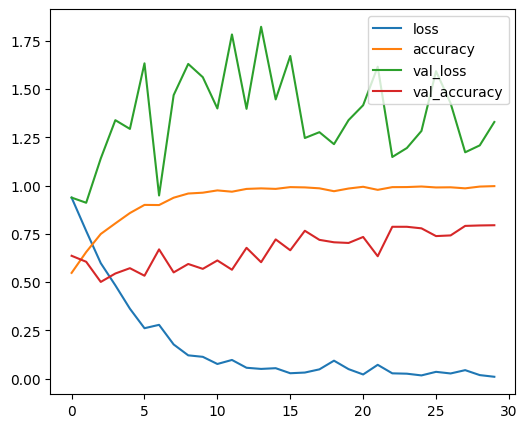

[[239  49   0]
 [ 50 248   4]
 [  7  69 206]]


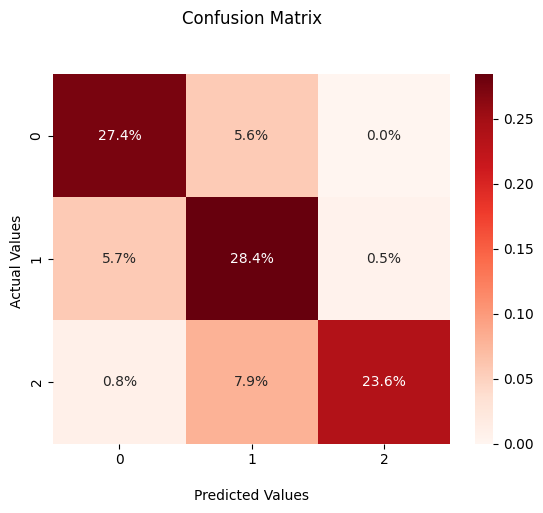

SUBJECT 14
7/7 [==============================] - 0s 9ms/step - loss: 1.8330 - accuracy: 0.7189
Score : loss of 1.833007574081421; accuracy of 71.89249992370605%
28/28 [==============================] - 0s 4ms/step
F1 score:  0.71575110268763
Precision:  0.7168150385514495
Recall:  0.7189249720044792


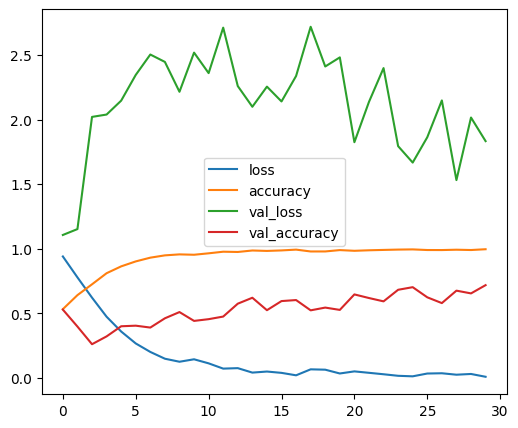

[[252  17  16]
 [ 18 213  69]
 [ 32  99 177]]


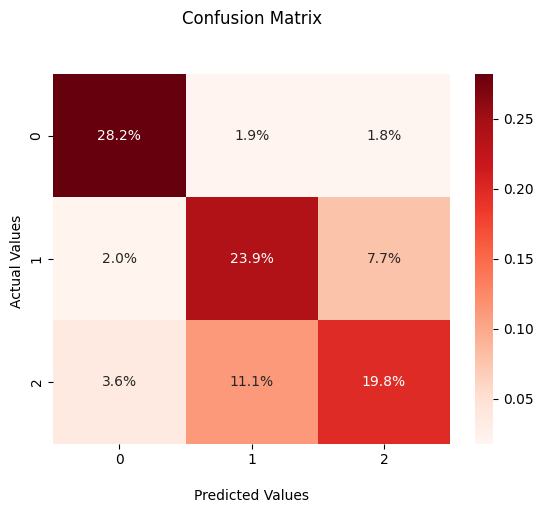

SUBJECT 15
7/7 [==============================] - 0s 8ms/step - loss: 0.7822 - accuracy: 0.7752
Score : loss of 0.7821546196937561; accuracy of 77.52028107643127%
27/27 [==============================] - 0s 4ms/step
F1 score:  0.7754409135520203
Precision:  0.7760571525820017
Recall:  0.7752027809965237


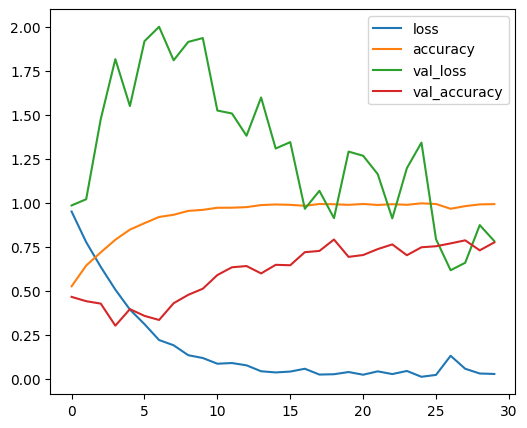

[[230  47  21]
 [ 21 227  39]
 [ 60   6 212]]


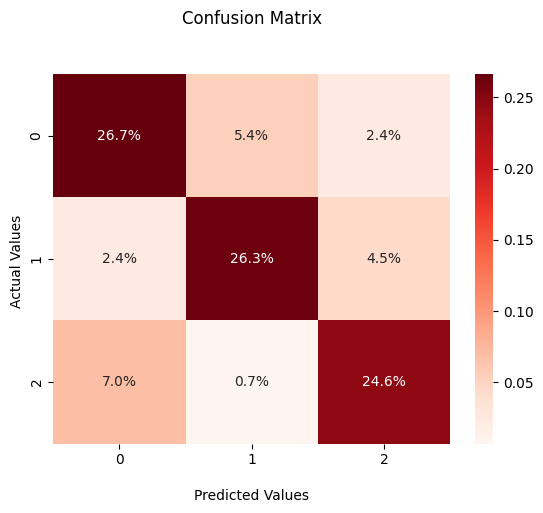

SUBJECT 16
7/7 [==============================] - 0s 9ms/step - loss: 1.2472 - accuracy: 0.7196
Score : loss of 1.2471946477890015; accuracy of 71.96367979049683%
28/28 [==============================] - 0s 4ms/step
F1 score:  0.7171066489217421
Precision:  0.727556100790087
Recall:  0.7196367763904654


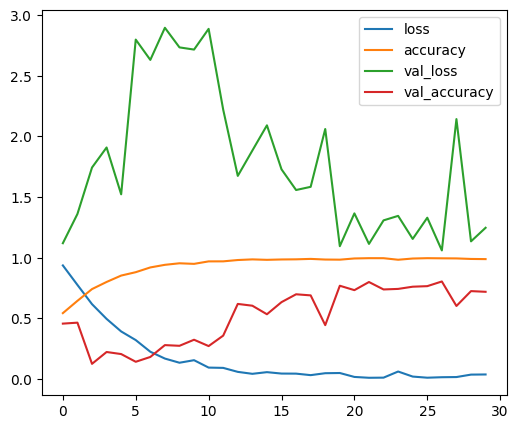

[[173 123   4]
 [ 30 207  56]
 [ 22  12 254]]


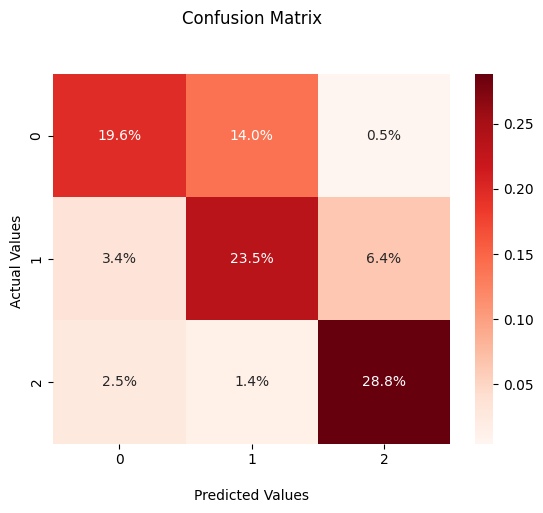

SUBJECT 17
7/7 [==============================] - 0s 10ms/step - loss: 1.5086 - accuracy: 0.7489
Score : loss of 1.5086125135421753; accuracy of 74.88738894462585%
28/28 [==============================] - 1s 4ms/step
F1 score:  0.7512989483007313
Precision:  0.7613915782567728
Recall:  0.7488738738738738


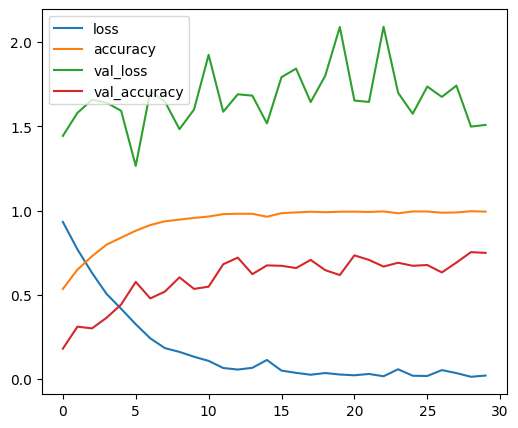

[[249  44  10]
 [  5 186 107]
 [ 10  47 230]]


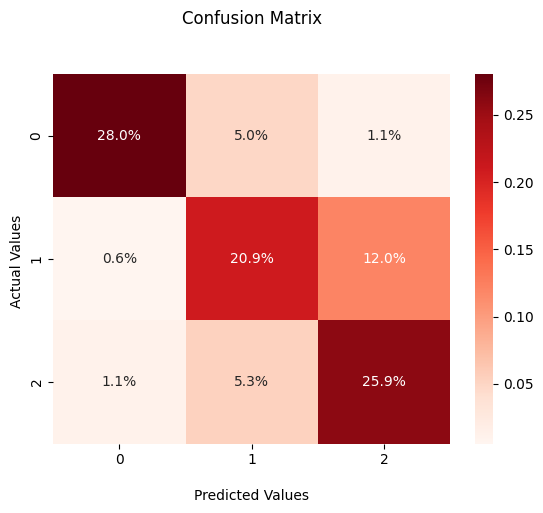

SUBJECT 18
7/7 [==============================] - 0s 8ms/step - loss: 0.9387 - accuracy: 0.8034
Score : loss of 0.938744068145752; accuracy of 80.34090995788574%
28/28 [==============================] - 0s 4ms/step
F1 score:  0.7966998368581084
Precision:  0.8020571178686303
Recall:  0.803409090909091


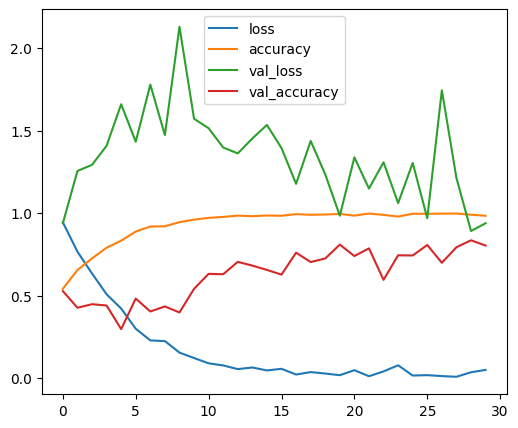

[[251  48   1]
 [ 83 175  35]
 [  6   0 281]]


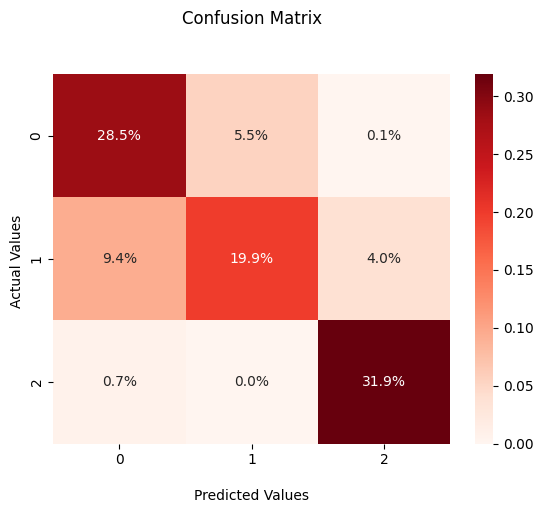

SUBJECT 19
7/7 [==============================] - 0s 10ms/step - loss: 1.2588 - accuracy: 0.7937
Score : loss of 1.2588162422180176; accuracy of 79.37062978744507%
27/27 [==============================] - 1s 4ms/step
F1 score:  0.7990002487098069
Precision:  0.8314615266570056
Recall:  0.7937062937062938


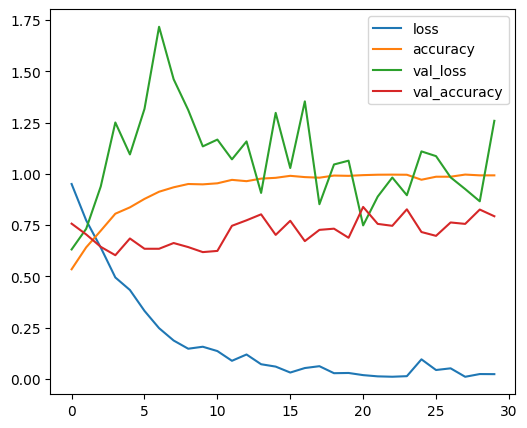

[[209  80   3]
 [ 31 258   0]
 [  0  63 214]]


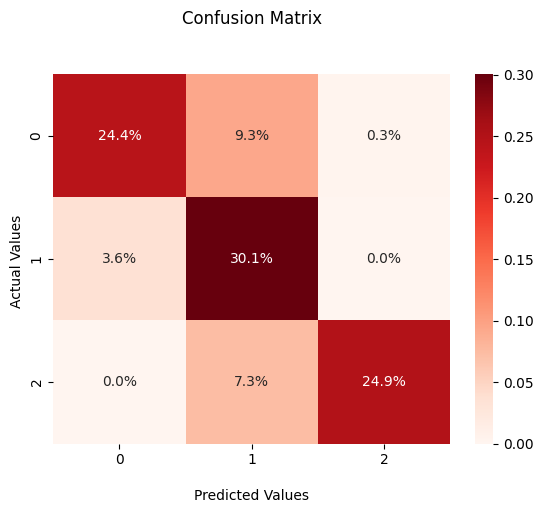

SUBJECT 20
7/7 [==============================] - 0s 9ms/step - loss: 1.2757 - accuracy: 0.7211
Score : loss of 1.275719404220581; accuracy of 72.1142828464508%
28/28 [==============================] - 0s 4ms/step
F1 score:  0.7233645076446081
Precision:  0.7472947880552444
Recall:  0.7211428571428572


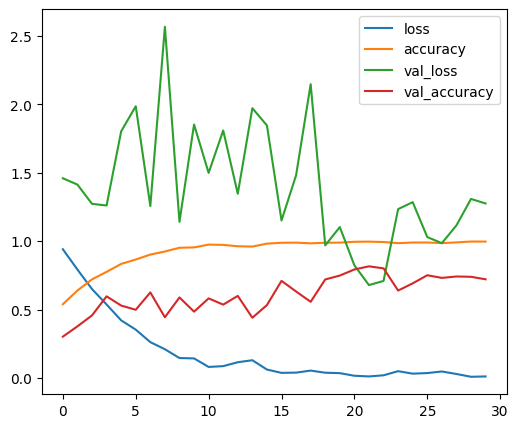

[[241  11  44]
 [  6 176 105]
 [ 66  12 214]]


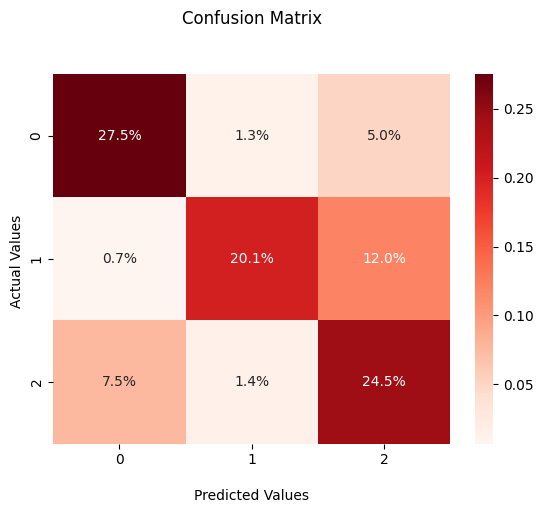

SUBJECT 21
7/7 [==============================] - 0s 9ms/step - loss: 2.3598 - accuracy: 0.6539
Score : loss of 2.359760284423828; accuracy of 65.389084815979%
27/27 [==============================] - 0s 4ms/step
F1 score:  0.6557513709981497
Precision:  0.6762217350397909
Recall:  0.6538908246225319


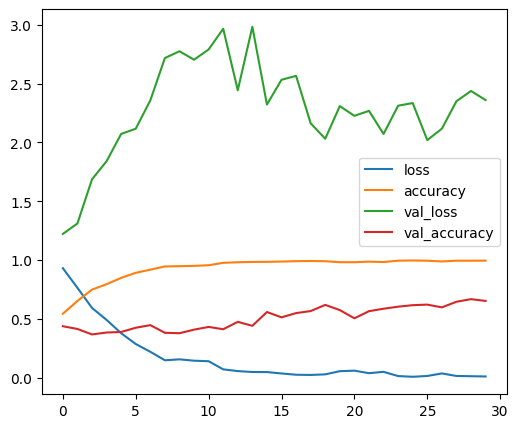

[[201  17  72]
 [ 34 152 103]
 [  8  64 210]]


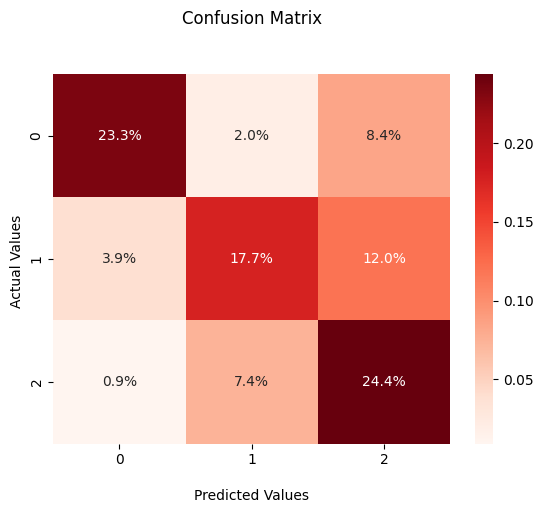

In [ ]:
from sklearn.model_selection import train_test_split

for sub in range(len(all_data)):

    print('SUBJECT',sub)

    test_data_all = all_data[sub]

    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(test_data_all['data'], test_data_all['label'], test_size=0.05, random_state=3456789)

    train_data, train_data_all = {}, {}
    test_data = {}
    
    train_data_all["data"] = np.concatenate([all_data[i]["data"] for i in range(len(all_data)) if i != sub])    
    train_data['data'] = np.concatenate((train_data_all['data'], X_test_split), axis=0)
    
    train_data_all["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])
    train_data["label"] = np.concatenate((train_data_all["label"], y_test_split), axis=0)
    
    test_data['data'] = X_train_split
    test_data['label'] = y_train_split

    cm_w_ft_5, acc_w_ft_5, loss_w_ft_5, f1_w_ft_5, prec_w_ft_5, rec_w_ft_5 = lstm(train_data, test_data)

#**Avearge accuracy and F1 score (5% ft)**

In [5]:
print(acc_w_ft_5)

[74.14187788963318, 27.82805562019348, 74.71526265144348, 74.20091032981873, 35.172414779663086, 75.02877116203308, 70.7150936126709, 72.76887893676758, 64.20187950134277, 74.45339560508728, 88.14489841461182, 71.39587998390198, 88.28306198120117, 79.47247624397278, 71.89249992370605, 77.52028107643127, 71.96367979049683, 74.88738894462585, 80.34090995788574, 79.37062978744507, 72.1142828464508, 65.389084815979]


In [6]:
print(np.mean(acc_w_ft_5))
print(np.mean(f1_w_ft_5))

71.090982447971
0.7091090867866289


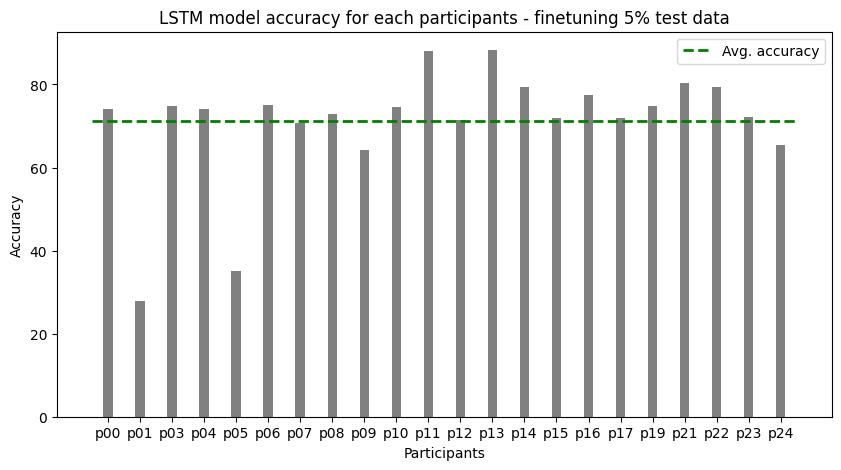

In [8]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_ft_5, color ='grey',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("LSTM model accuracy for each participants - finetuning 5% test data")

plt.hlines(y=(np.mean(acc_w_ft_5)), xmin=-0.5, xmax=(len(acc_w_ft_5)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

[[[173, 81, 42], [69, 225, 6], [19, 9, 250]], [[132, 31, 131], [47, 73, 182], [80, 167, 41]], [[194, 33, 71], [7, 271, 13], [5, 93, 191]], [[127, 156, 0], [30, 251, 26], [0, 14, 272]], [[92, 107, 82], [78, 132, 90], [96, 111, 82]], [[216, 25, 39], [15, 228, 60], [37, 41, 208]], [[236, 18, 42], [5, 261, 30], [108, 55, 126]], [[175, 43, 82], [30, 220, 41], [0, 42, 241]], [[132, 75, 79], [12, 226, 55], [48, 36, 189]], [[201, 79, 7], [6, 294, 7], [44, 79, 152]], [[246, 53, 11], [10, 274, 20], [14, 0, 283]], [[254, 19, 10], [86, 179, 41], [48, 46, 191]], [[211, 47, 15], [14, 268, 9], [1, 15, 282]], [[239, 49, 0], [50, 248, 4], [7, 69, 206]], [[252, 17, 16], [18, 213, 69], [32, 99, 177]], [[230, 47, 21], [21, 227, 39], [60, 6, 212]], [[173, 123, 4], [30, 207, 56], [22, 12, 254]], [[249, 44, 10], [5, 186, 107], [10, 47, 230]], [[251, 48, 1], [83, 175, 35], [6, 0, 281]], [[209, 80, 3], [31, 258, 0], [0, 63, 214]], [[241, 11, 44], [6, 176, 105], [66, 12, 214]], [[201, 17, 72], [34, 152, 103], [

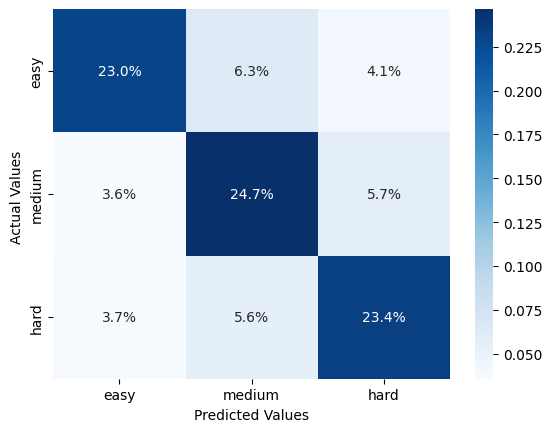

In [4]:
# cm_w_ft_5 seperated by commas

print(cm_w_ft_5)

ele_00, ele_01, ele_02 = [], [], []
ele_10, ele_11, ele_12 = [], [], []
ele_20, ele_21, ele_22 = [], [], []

for i in range(len(cm_w_ft_5)):
  ele_00.append(cm_w_ft_5[i][0][0])
  ele_01.append(cm_w_ft_5[i][0][1])
  ele_02.append(cm_w_ft_5[i][0][2])
  ele_10.append(cm_w_ft_5[i][1][0])
  ele_11.append(cm_w_ft_5[i][1][1])
  ele_12.append(cm_w_ft_5[i][1][2])
  ele_20.append(cm_w_ft_5[i][2][0])
  ele_21.append(cm_w_ft_5[i][2][1])
  ele_22.append(cm_w_ft_5[i][2][2])

cm = [[ np.mean(ele_00), np.mean(ele_01), np.mean(ele_02)],
      [ np.mean(ele_10), np.mean(ele_11), np.mean(ele_12)],
      [ np.mean(ele_20), np.mean(ele_21), np.mean(ele_22)]]

print(cm)

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues')
ax.figsize=(5,5)
#ax.set_title('\nConfusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');
    
ax.xaxis.set_ticklabels(['easy','medium','hard'])
ax.yaxis.set_ticklabels(['easy','medium','hard'])

#plt.savefig('lstm_cm_ft_5.pdf')

plt.show()

#**Finetuning 10% of test data (LOSO)**

SUBJECT 0
7/7 [==============================] - 0s 5ms/step - loss: 0.3192 - accuracy: 0.9070
Score : loss of 0.31922271847724915; accuracy of 90.70048332214355%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.9065348751231448
Precision:  0.9072706794372646
Recall:  0.9070048309178744


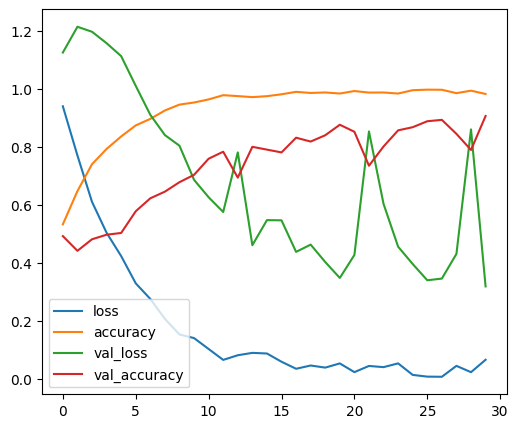

[[241  27  16]
 [ 16 264   5]
 [  7   6 246]]


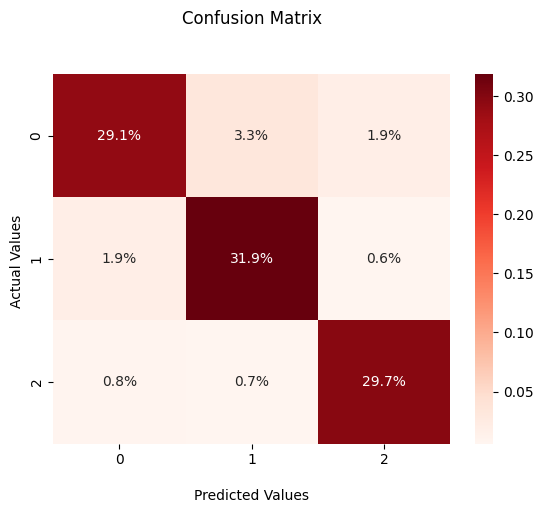

SUBJECT 1
7/7 [==============================] - 0s 5ms/step - loss: 1.5264 - accuracy: 0.6738
Score : loss of 1.5264275074005127; accuracy of 67.38350987434387%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.6635488555220725
Precision:  0.6805425170088881
Recall:  0.6738351254480287


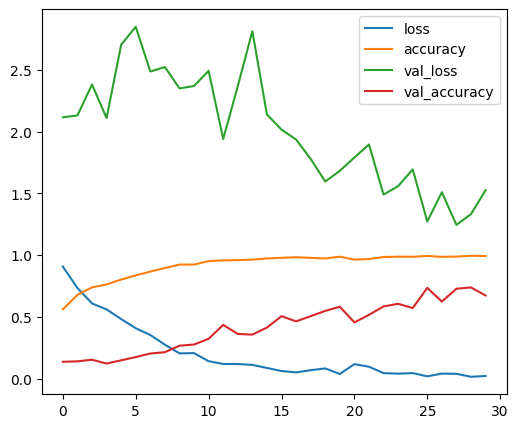

[[251  12  10]
 [ 63 171  53]
 [ 74  61 142]]


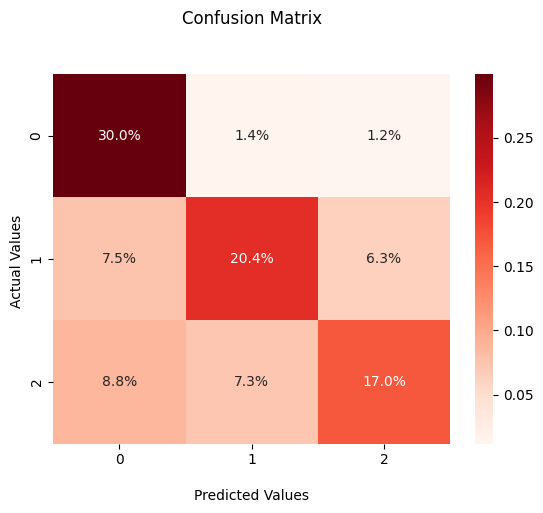

SUBJECT 2
7/7 [==============================] - 0s 5ms/step - loss: 0.3396 - accuracy: 0.8966
Score : loss of 0.33958423137664795; accuracy of 89.66346383094788%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.8956120500404846
Precision:  0.8971491017644865
Recall:  0.8966346153846154


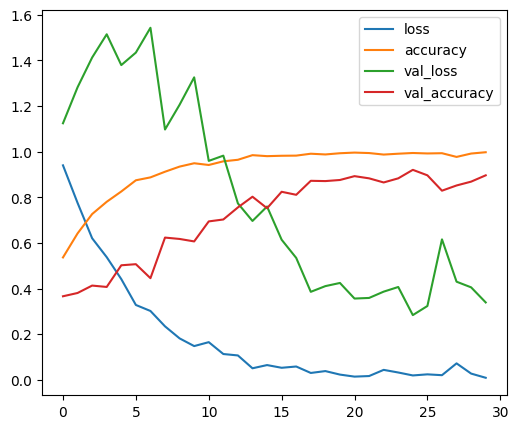

[[239  17  26]
 [ 34 239   6]
 [  0   3 268]]


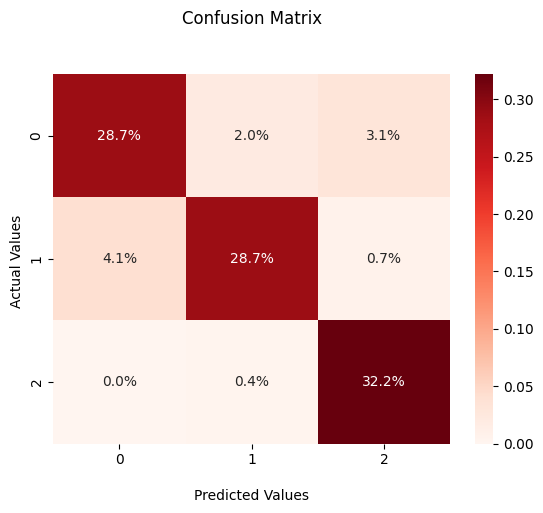

SUBJECT 3
7/7 [==============================] - 0s 5ms/step - loss: 0.4553 - accuracy: 0.8928
Score : loss of 0.4553411602973938; accuracy of 89.2771065235138%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.8925512462652094
Precision:  0.8953211228890493
Recall:  0.8927710843373494


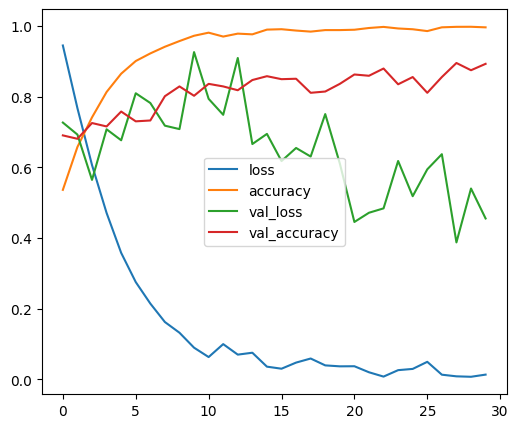

[[214  56   0]
 [ 28 260   2]
 [  0   3 267]]


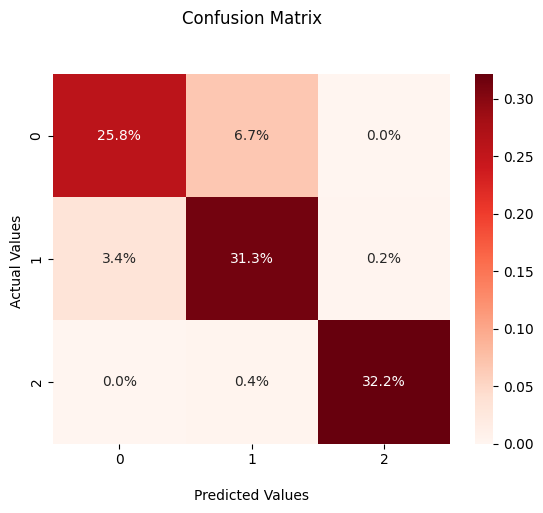

SUBJECT 4
7/7 [==============================] - 0s 5ms/step - loss: 1.0988 - accuracy: 0.6590
Score : loss of 1.0988019704818726; accuracy of 65.89806079864502%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.6600750418889807
Precision:  0.6638432436134907
Recall:  0.6589805825242718


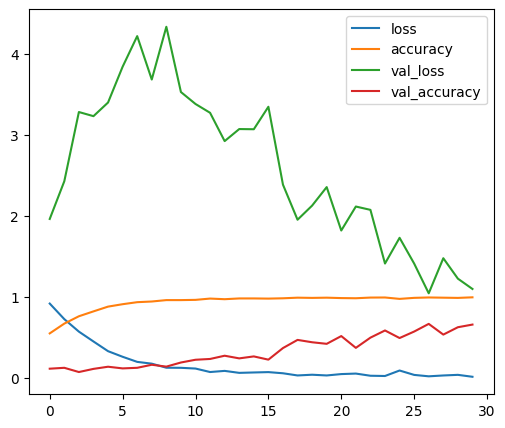

[[186  37  45]
 [ 19 203  64]
 [ 96  20 154]]


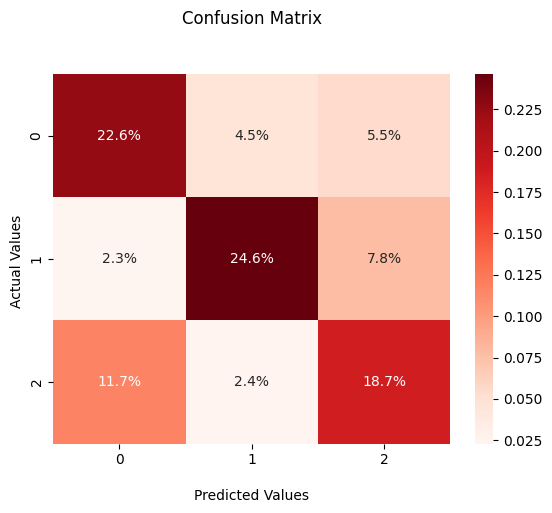

SUBJECT 5
7/7 [==============================] - 0s 5ms/step - loss: 0.5153 - accuracy: 0.8700
Score : loss of 0.5152656435966492; accuracy of 86.99878454208374%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.8681834417013519
Precision:  0.8733817167530649
Recall:  0.8699878493317132


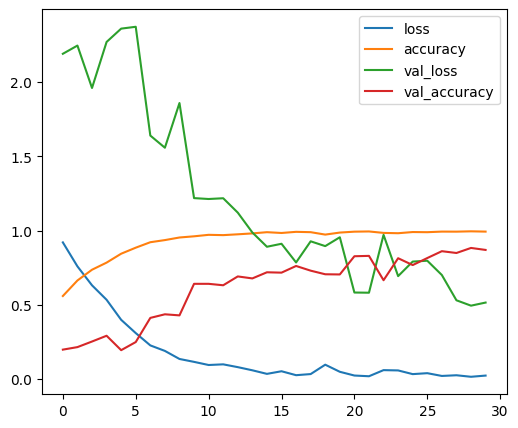

[[237  15  15]
 [  7 277   4]
 [ 45  21 202]]


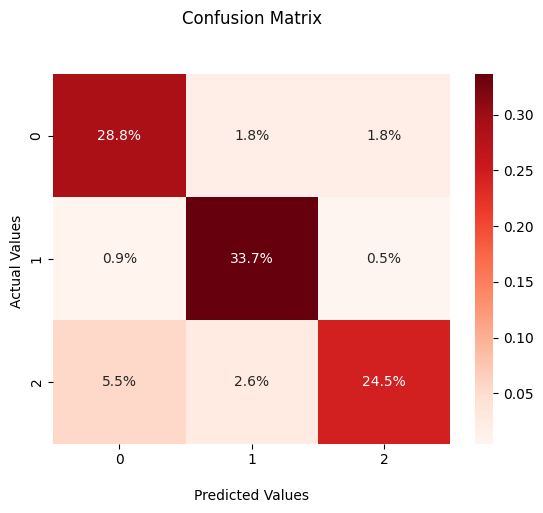

SUBJECT 6
7/7 [==============================] - 0s 5ms/step - loss: 0.4001 - accuracy: 0.9054
Score : loss of 0.400097131729126; accuracy of 90.53892493247986%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.9052581229685843
Precision:  0.911474737058746
Recall:  0.9053892215568863


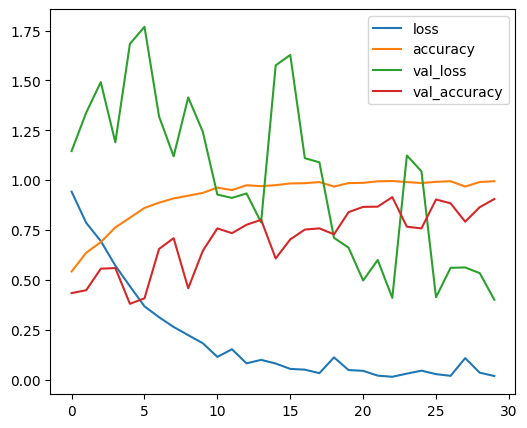

[[267   1   6]
 [  8 264  13]
 [ 46   5 225]]


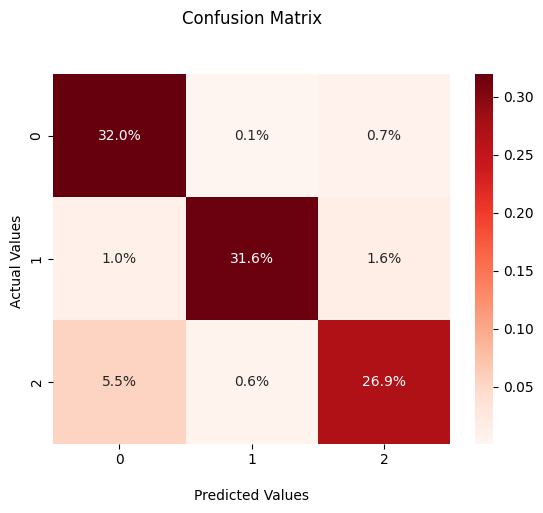

SUBJECT 7
7/7 [==============================] - 0s 5ms/step - loss: 0.5482 - accuracy: 0.8659
Score : loss of 0.5482046008110046; accuracy of 86.59420013427734%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.8657173257337715
Precision:  0.8738597073128794
Recall:  0.8659420289855072


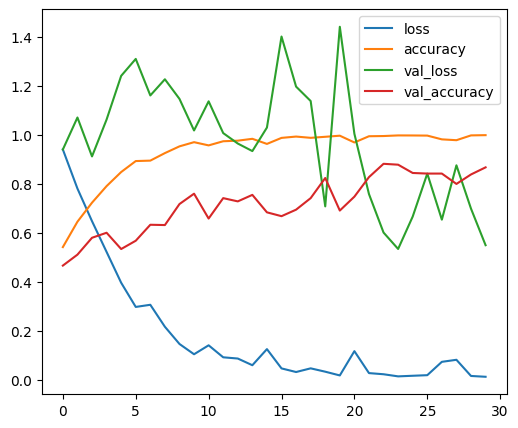

[[221  13  50]
 [ 12 253  11]
 [  0  25 243]]


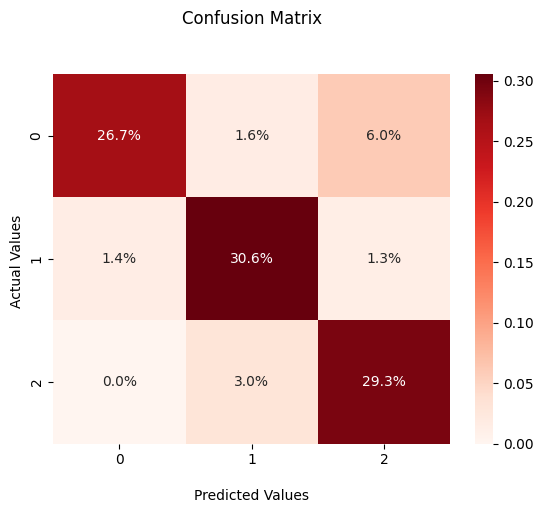

SUBJECT 8
7/7 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.8067
Score : loss of 0.6823429465293884; accuracy of 80.66914677619934%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.7993464519738823
Precision:  0.8217580094717118
Recall:  0.8066914498141264


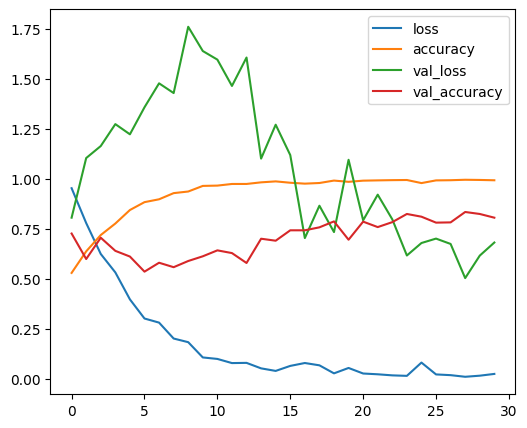

[[157  36  77]
 [  5 263  12]
 [ 14  12 231]]


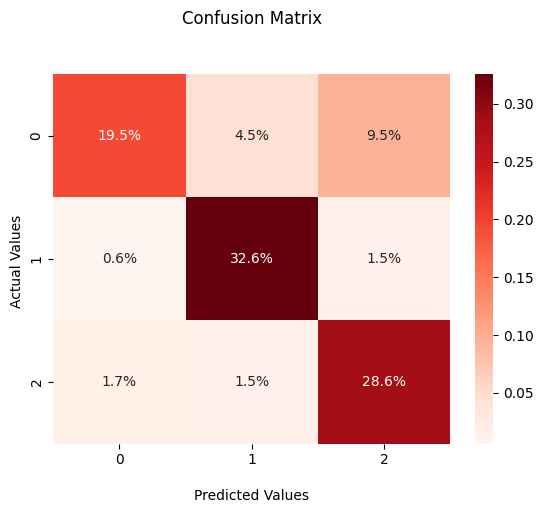

SUBJECT 9
7/7 [==============================] - 0s 5ms/step - loss: 0.4575 - accuracy: 0.8724
Score : loss of 0.45747941732406616; accuracy of 87.24179863929749%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.8728186513297987
Precision:  0.8790740710537619
Recall:  0.8724179829890644


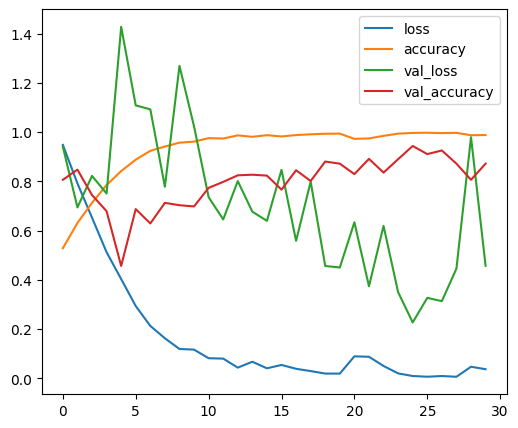

[[216  38  15]
 [ 22 270   0]
 [  0  30 232]]


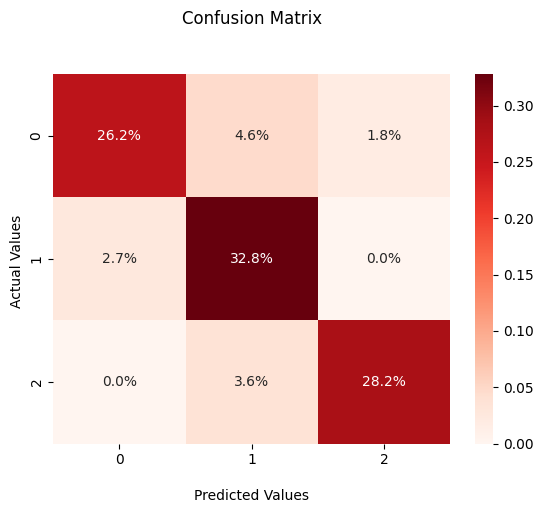

SUBJECT 10
7/7 [==============================] - 0s 5ms/step - loss: 0.1539 - accuracy: 0.9641
Score : loss of 0.15385596454143524; accuracy of 96.40787839889526%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.9640632135600188
Precision:  0.964351051406995
Recall:  0.9640787949015064


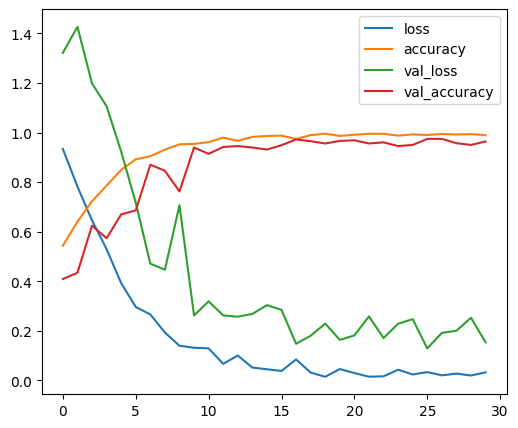

[[272  14   3]
 [  4 291   0]
 [ 10   0 269]]


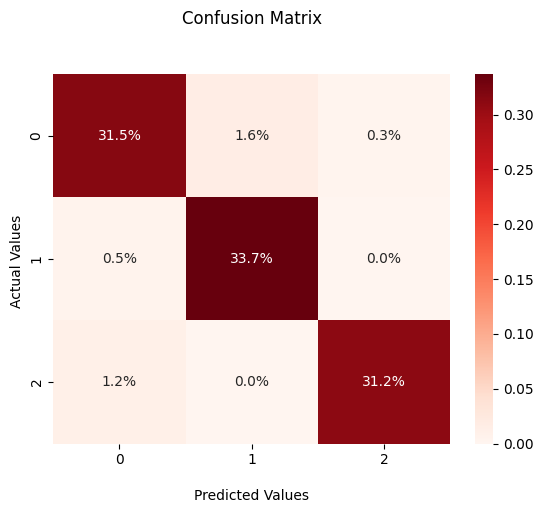

SUBJECT 11
7/7 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.8575
Score : loss of 0.6945679783821106; accuracy of 85.74879169464111%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.8531048301038241
Precision:  0.8634965630931566
Recall:  0.857487922705314


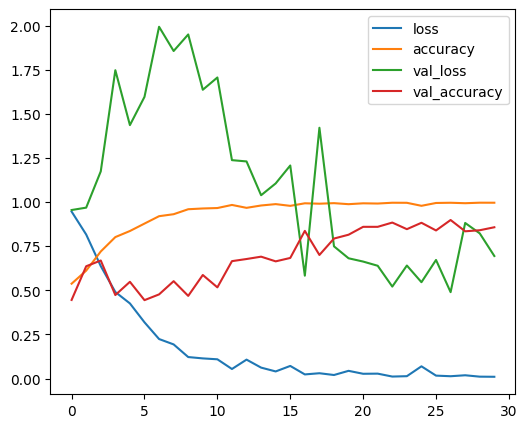

[[256   8   0]
 [ 53 200  37]
 [  6  14 254]]


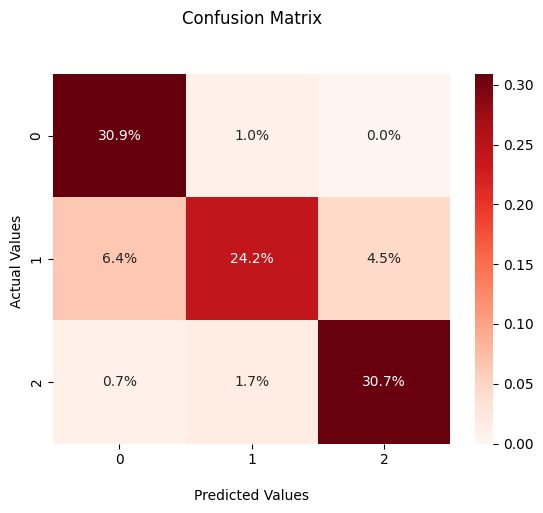

SUBJECT 12
7/7 [==============================] - 0s 5ms/step - loss: 0.6580 - accuracy: 0.8947
Score : loss of 0.658044695854187; accuracy of 89.47368264198303%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.8955785133880688
Precision:  0.8972209947075992
Recall:  0.8947368421052632


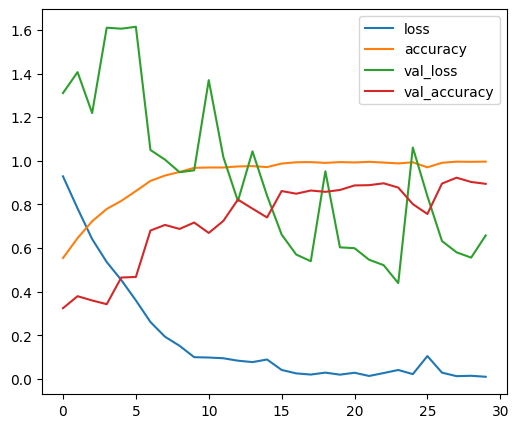

[[223  29   3]
 [ 36 241   2]
 [ 12   4 267]]


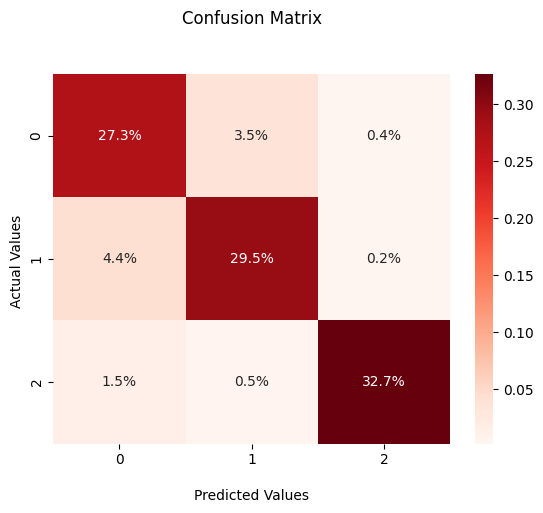

SUBJECT 13
7/7 [==============================] - 0s 5ms/step - loss: 0.6334 - accuracy: 0.8608
Score : loss of 0.6333540678024292; accuracy of 86.077481508255%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.8619467169097969
Precision:  0.8694306470563764
Recall:  0.860774818401937


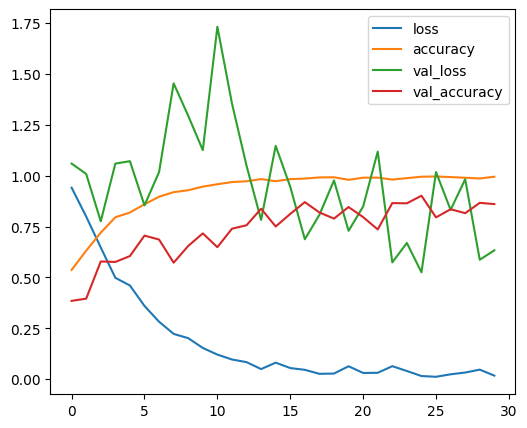

[[246  26   5]
 [ 35 245   0]
 [ 15  34 220]]


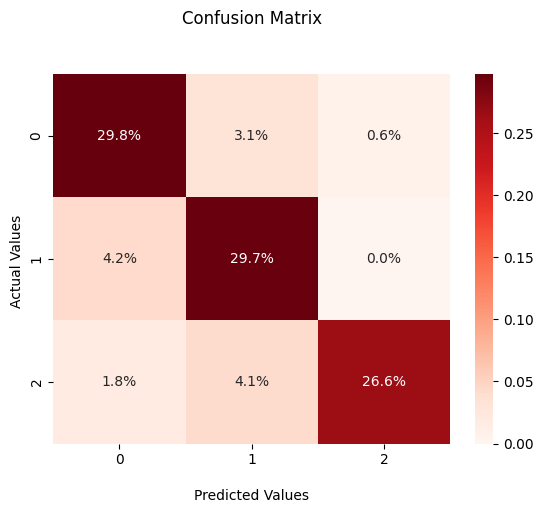

SUBJECT 14
7/7 [==============================] - 0s 5ms/step - loss: 1.2871 - accuracy: 0.8298
Score : loss of 1.2870856523513794; accuracy of 82.97872543334961%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.8301144479138826
Precision:  0.8309328779895294
Recall:  0.8297872340425532


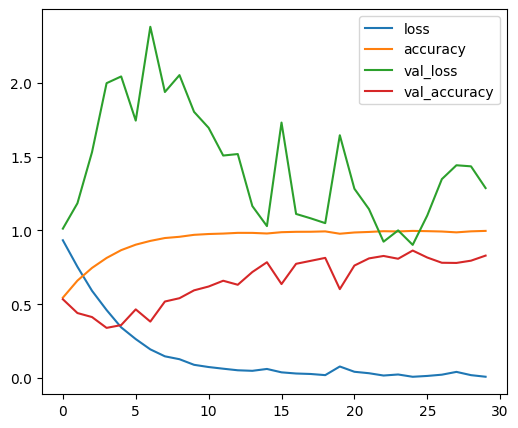

[[233  18  18]
 [ 17 235  33]
 [ 12  46 234]]


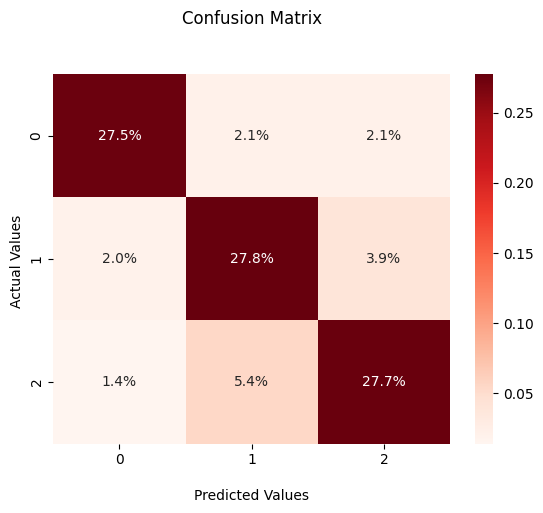

SUBJECT 15
7/7 [==============================] - 0s 5ms/step - loss: 0.9268 - accuracy: 0.7555
Score : loss of 0.9267610907554626; accuracy of 75.55012106895447%
26/26 [==============================] - 1s 3ms/step
F1 score:  0.7512013082595804
Precision:  0.7857550796032342
Recall:  0.7555012224938875


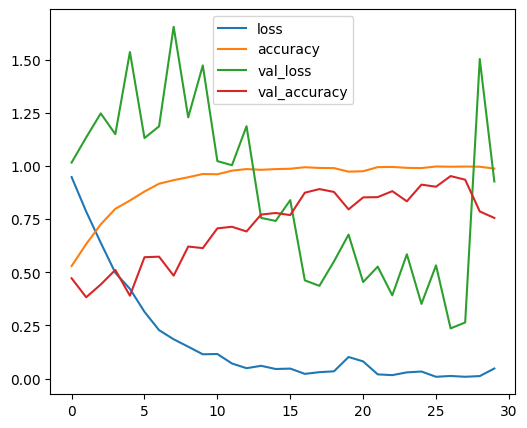

[[182  59  44]
 [ 12 180  81]
 [  3   1 256]]


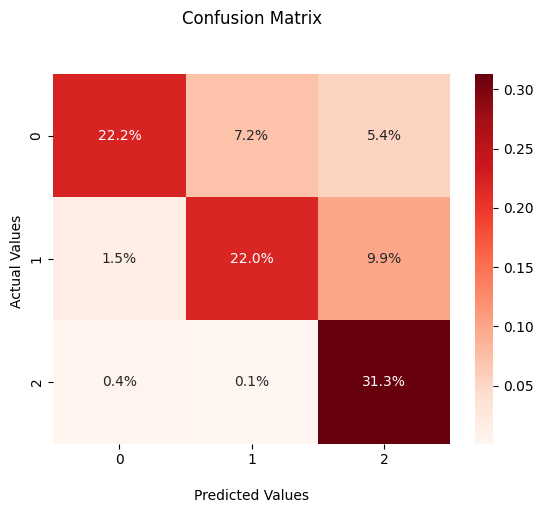

SUBJECT 16
7/7 [==============================] - 0s 5ms/step - loss: 0.5253 - accuracy: 0.8299
Score : loss of 0.5252954363822937; accuracy of 82.9940140247345%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.8292191230511878
Precision:  0.8288877646505203
Recall:  0.829940119760479


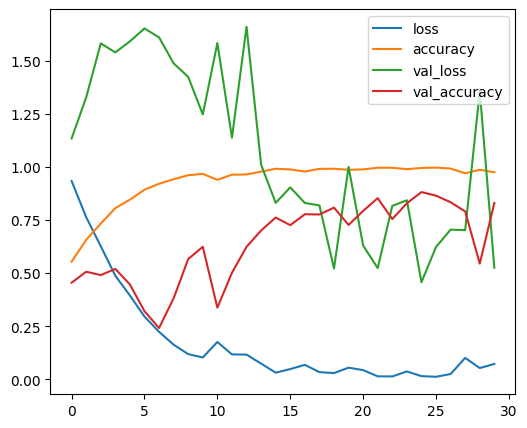

[[226  56   6]
 [ 55 212  13]
 [ 12   0 255]]


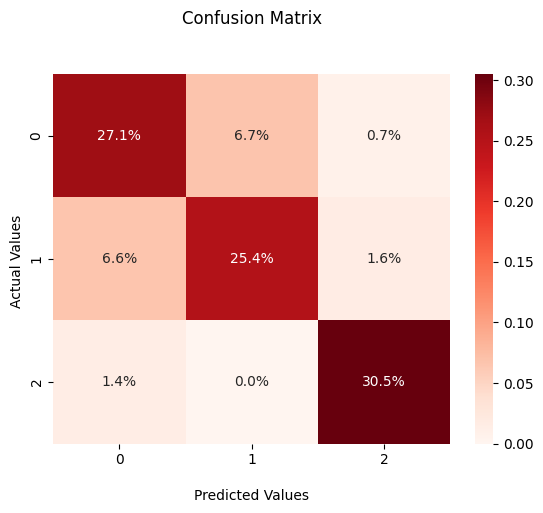

SUBJECT 17
7/7 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.8859
Score : loss of 0.6912871599197388; accuracy of 88.5850191116333%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.8847712870053882
Precision:  0.886373935174521
Recall:  0.8858501783590963


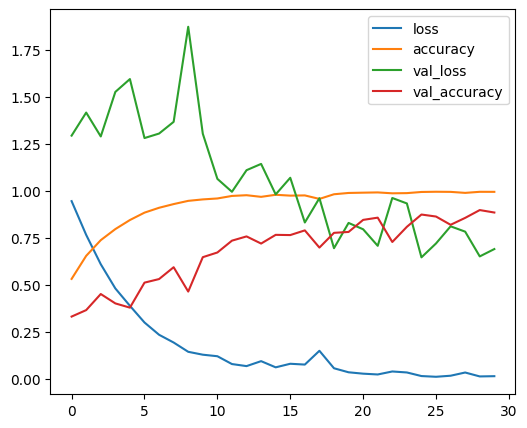

[[286   2   0]
 [  1 231  50]
 [ 23  20 228]]


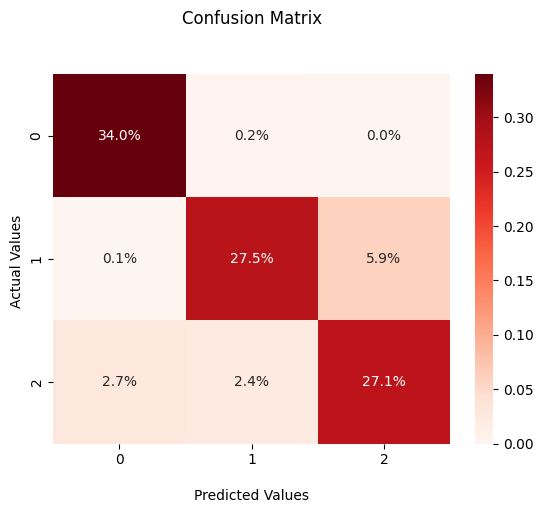

SUBJECT 18
7/7 [==============================] - 0s 5ms/step - loss: 0.3162 - accuracy: 0.9197
Score : loss of 0.3161986172199249; accuracy of 91.96642637252808%
27/27 [==============================] - 0s 3ms/step
F1 score:  0.9196774500978976
Precision:  0.9202897045355903
Recall:  0.919664268585132


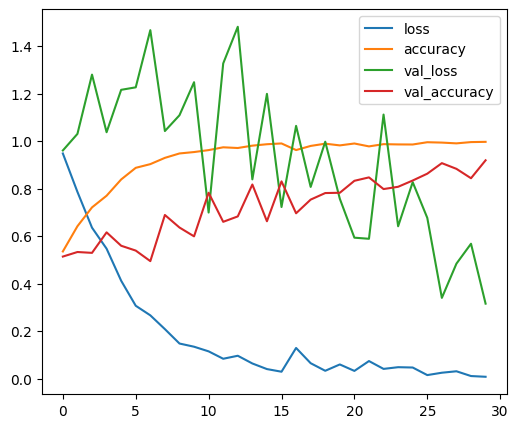

[[259  22   5]
 [ 34 245   1]
 [  5   0 263]]


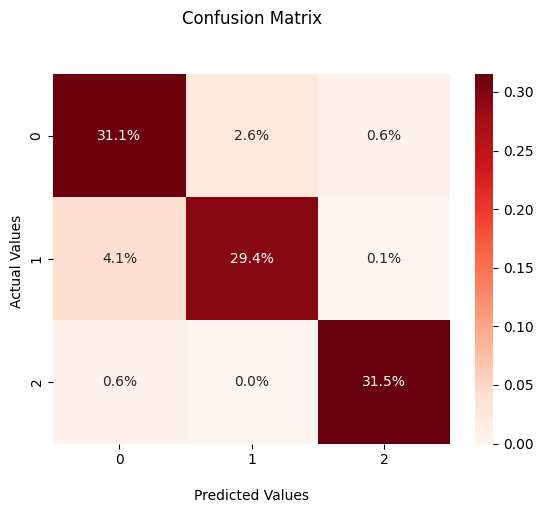

SUBJECT 19
7/7 [==============================] - 0s 5ms/step - loss: 0.2844 - accuracy: 0.8585
Score : loss of 0.28444379568099976; accuracy of 85.85485816001892%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.8576627631693471
Precision:  0.8753275828686404
Recall:  0.8585485854858549


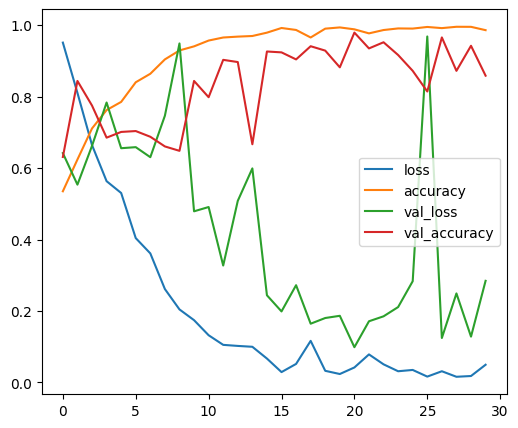

[[272   6   0]
 [ 35 238   1]
 [  0  73 188]]


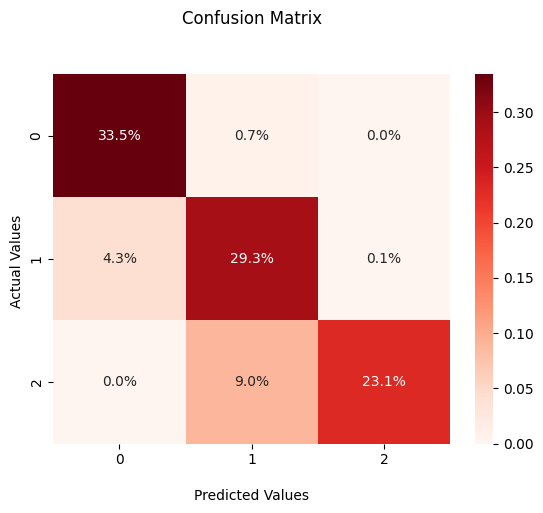

SUBJECT 20
7/7 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.7346
Score : loss of 0.688226580619812; accuracy of 73.46200346946716%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.7313567348488357
Precision:  0.7376311063943992
Recall:  0.7346200241254524


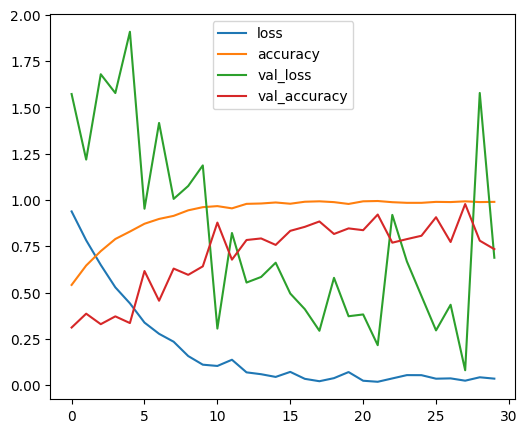

[[248   9  22]
 [ 20 189  62]
 [ 74  33 172]]


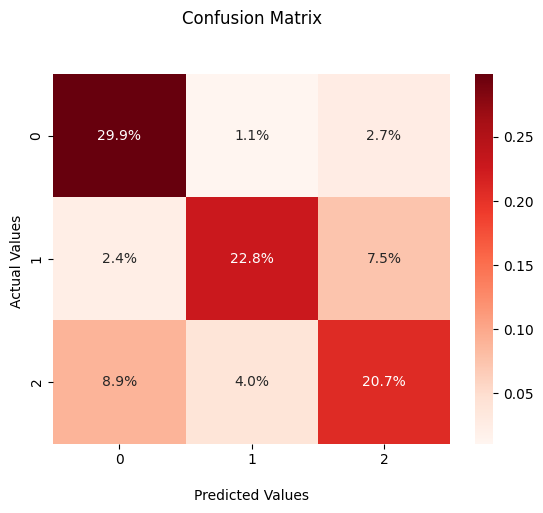

SUBJECT 21
7/7 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.7672
Score : loss of 0.6937323808670044; accuracy of 76.71568393707275%
26/26 [==============================] - 0s 3ms/step
F1 score:  0.7633076156277713
Precision:  0.7724284000190873
Recall:  0.7671568627450981


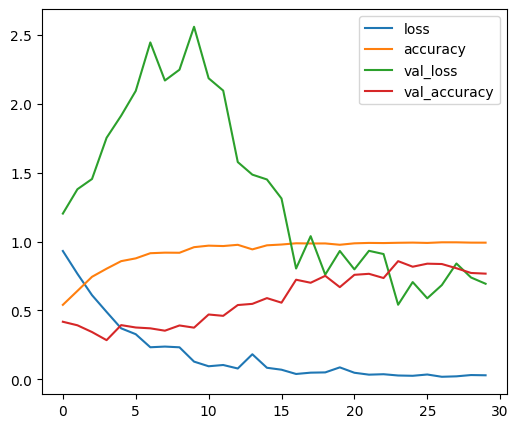

[[169  29  77]
 [ 41 215  18]
 [ 12  13 242]]


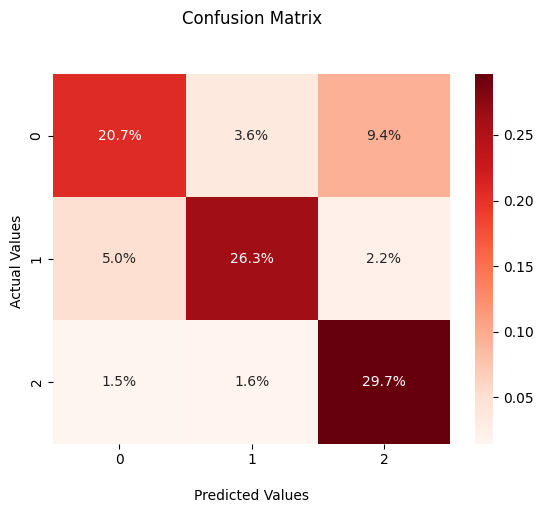

In [ ]:
from sklearn.model_selection import train_test_split

for sub in range(len(all_data)):

    print('SUBJECT',sub)

    test_data_all = all_data[sub]

    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(test_data_all['data'], test_data_all['label'], test_size=0.1, random_state=3456789)

    train_data, train_data_all = {}, {}
    test_data = {}
    
    train_data_all["data"] = np.concatenate([all_data[i]["data"] for i in range(len(all_data)) if i != sub])    
    train_data['data'] = np.concatenate((train_data_all['data'], X_test_split), axis=0)
    
    train_data_all["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])
    train_data["label"] = np.concatenate((train_data_all["label"], y_test_split), axis=0)
    
    test_data['data'] = X_train_split
    test_data['label'] = y_train_split

    cm_w_ft_10, acc_w_ft_10, loss_w_ft_10, f1_w_ft_10, prec_w_ft_10, rec_w_ft_10 = lstm(train_data, test_data)

#**Average accuracy and F1 score (10% ft)**

In [9]:
print(acc_w_ft_10)

[90.70048332214355, 67.38350987434387, 89.66346383094788, 89.2771065235138, 65.89806079864502, 86.99878454208374, 90.53892493247986, 86.59420013427734, 80.66914677619934, 87.24179863929749, 96.40787839889526, 85.74879169464111, 89.47368264198303, 86.077481508255, 82.97872543334961, 75.55012106895447, 82.9940140247345, 88.5850191116333, 91.96642637252808, 85.85485816001892, 73.46200346946716, 76.71568393707275]


In [10]:
print(np.mean(acc_w_ft_10))
print(np.mean(f1_w_ft_10))

84.12637114524841
0.8396204575674037


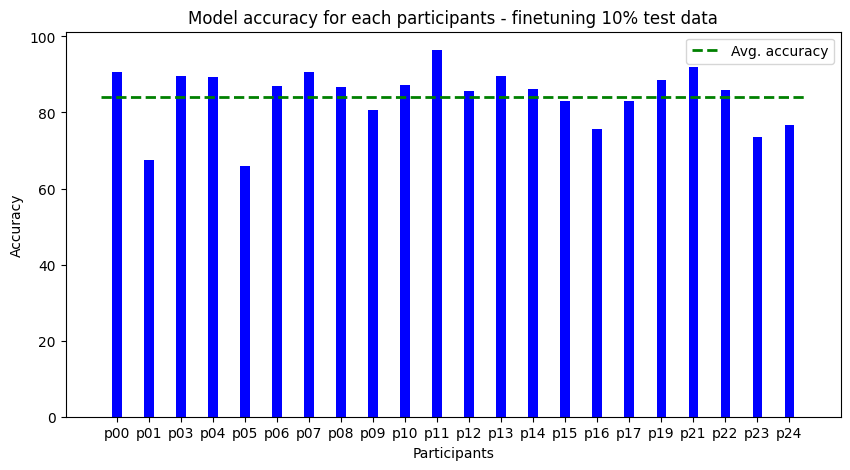

In [13]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_ft_10, color ='blue',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("Model accuracy for each participants - finetuning 10% test data")

plt.hlines(y=(np.mean(acc_w_ft_10)), xmin=-0.5, xmax=(len(acc_w_ft_10)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

[[[241, 27, 16], [16, 264, 5], [7, 6, 246]], [[251, 12, 10], [63, 171, 53], [74, 61, 142]], [[239, 17, 26], [34, 239, 6], [0, 3, 268]], [[214, 56, 0], [28, 260, 2], [0, 3, 267]], [[186, 37, 45], [19, 203, 64], [96, 20, 154]], [[237, 15, 15], [7, 277, 4], [45, 21, 202]], [[267, 1, 6], [8, 264, 13], [46, 5, 225]], [[221, 13, 50], [12, 253, 11], [0, 25, 243]], [[157, 36, 77], [5, 263, 12], [14, 12, 231]], [[216, 38, 15], [22, 270, 0], [0, 30, 232]], [[272, 14, 3], [4, 291, 0], [10, 0, 269]], [[256, 8, 0], [53, 200, 37], [6, 14, 254]], [[223, 29, 3], [36, 241, 2], [12, 4, 267]], [[246, 26, 5], [35, 245, 0], [15, 34, 220]], [[233, 18, 18], [17, 235, 33], [12, 46, 234]], [[182, 59, 44], [12, 180, 81], [3, 1, 256]], [[226, 56, 6], [55, 212, 13], [12, 0, 255]], [[286, 2, 0], [1, 231, 50], [23, 20, 228]], [[259, 22, 5], [34, 245, 1], [5, 0, 263]], [[272, 6, 0], [35, 238, 1], [0, 73, 188]], [[248, 9, 22], [20, 189, 62], [74, 33, 172]], [[169, 29, 77], [41, 215, 18], [12, 13, 242]]]
[[231.8636363

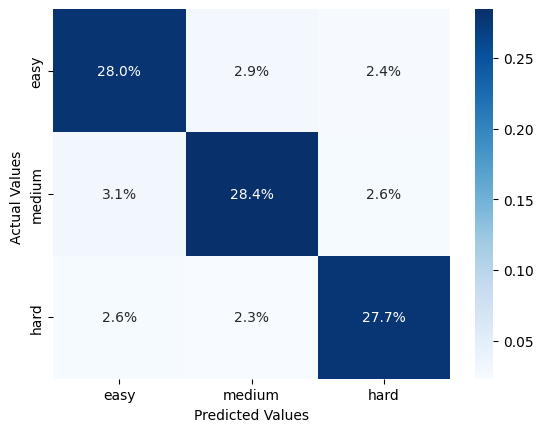

In [5]:
# cm_w_ft_10 seperated by commas

print(cm_w_ft_10)

ele_00, ele_01, ele_02 = [], [], []
ele_10, ele_11, ele_12 = [], [], []
ele_20, ele_21, ele_22 = [], [], []

for i in range(len(cm_w_ft_10)):
  ele_00.append(cm_w_ft_10[i][0][0])
  ele_01.append(cm_w_ft_10[i][0][1])
  ele_02.append(cm_w_ft_10[i][0][2])
  ele_10.append(cm_w_ft_10[i][1][0])
  ele_11.append(cm_w_ft_10[i][1][1])
  ele_12.append(cm_w_ft_10[i][1][2])
  ele_20.append(cm_w_ft_10[i][2][0])
  ele_21.append(cm_w_ft_10[i][2][1])
  ele_22.append(cm_w_ft_10[i][2][2])

cm = [[ np.mean(ele_00), np.mean(ele_01), np.mean(ele_02)],
      [ np.mean(ele_10), np.mean(ele_11), np.mean(ele_12)],
      [ np.mean(ele_20), np.mean(ele_21), np.mean(ele_22)]]

print(cm)

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues')
ax.figsize=(5,5)
#ax.set_title('\nConfusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');
    
ax.xaxis.set_ticklabels(['easy','medium','hard'])
ax.yaxis.set_ticklabels(['easy','medium','hard'])

#plt.savefig('lstm_cm_ft_10.pdf')

plt.show()

#**Finetuning 20% of test data (LOSO)**

SUBJECT 0
6/6 [==============================] - 0s 5ms/step - loss: 0.0857 - accuracy: 0.9715
Score : loss of 0.08572356402873993; accuracy of 97.146737575531%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.9713841425543578
Precision:  0.9716979826212847
Recall:  0.9714673913043478


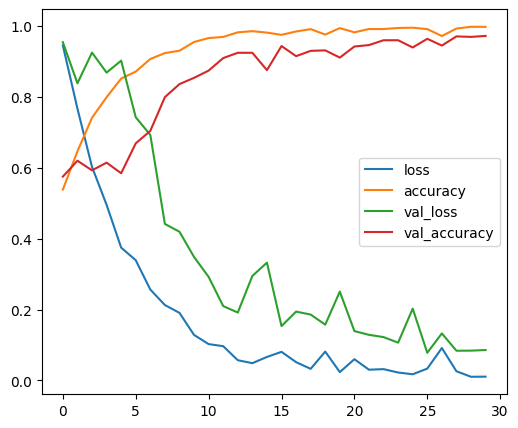

[[247   3   2]
 [  6 237   8]
 [  0   2 231]]


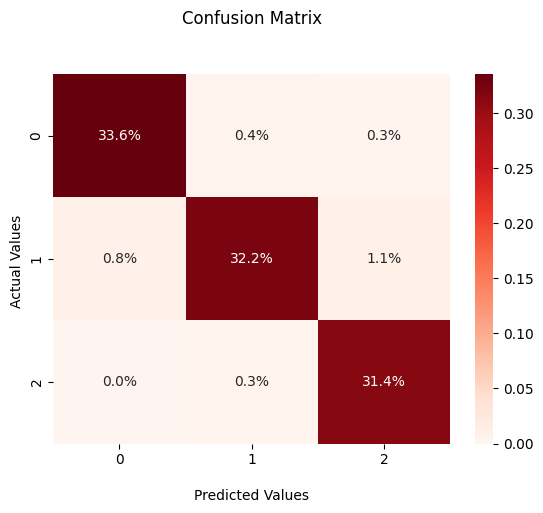

SUBJECT 1
6/6 [==============================] - 0s 5ms/step - loss: 1.2603 - accuracy: 0.7406
Score : loss of 1.2602888345718384; accuracy of 74.05914068222046%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.7374784808982849
Precision:  0.7472148166779761
Recall:  0.7405913978494624


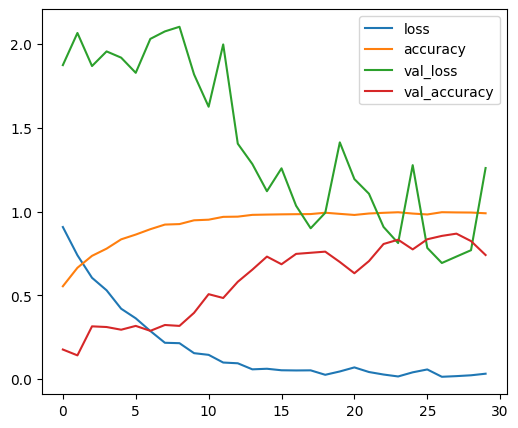

[[205  30  11]
 [ 20 201  32]
 [ 76  24 145]]


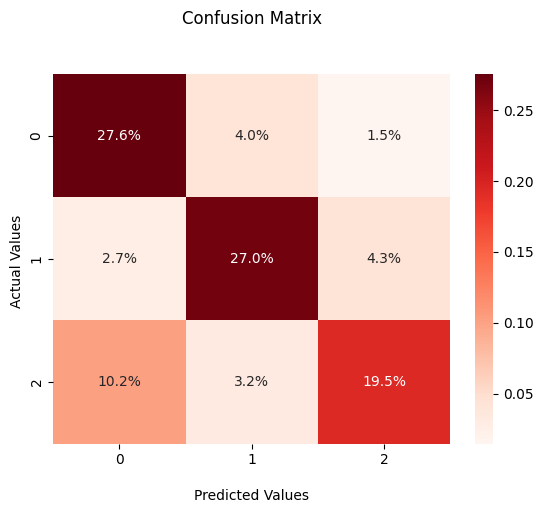

SUBJECT 2
6/6 [==============================] - 0s 5ms/step - loss: 0.1523 - accuracy: 0.9486
Score : loss of 0.15232546627521515; accuracy of 94.86486315727234%
24/24 [==============================] - 0s 4ms/step
F1 score:  0.9483859266692013
Precision:  0.9497205415292331
Recall:  0.9486486486486486


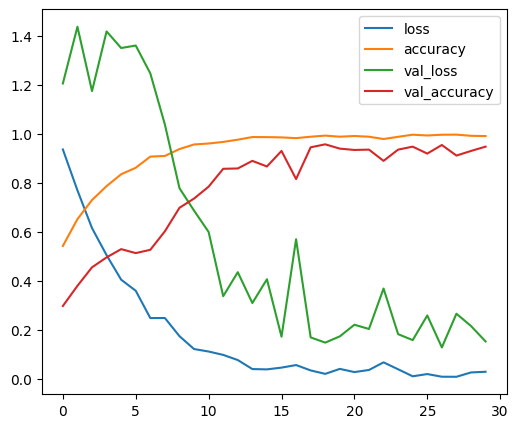

[[226  15   7]
 [  5 229  11]
 [  0   0 247]]


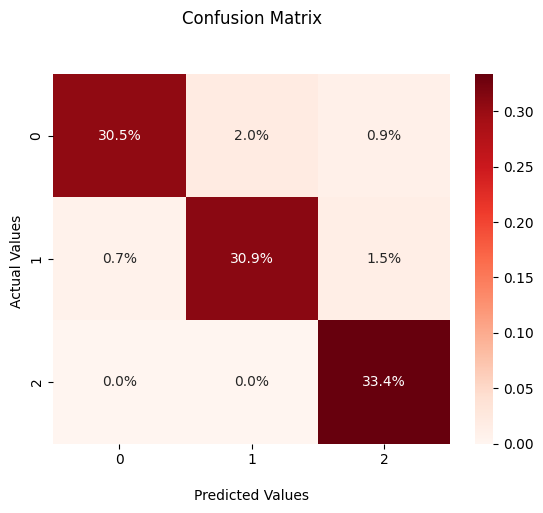

SUBJECT 3
6/6 [==============================] - 0s 5ms/step - loss: 0.2976 - accuracy: 0.9268
Score : loss of 0.2975805401802063; accuracy of 92.68292784690857%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.9271557505036458
Precision:  0.9281053914635667
Recall:  0.926829268292683


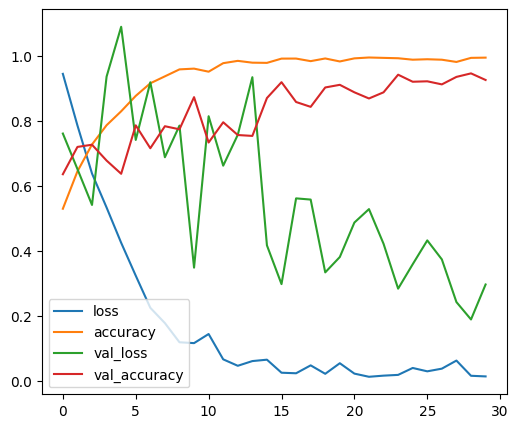

[[223  24   2]
 [ 17 233   1]
 [  3   7 228]]


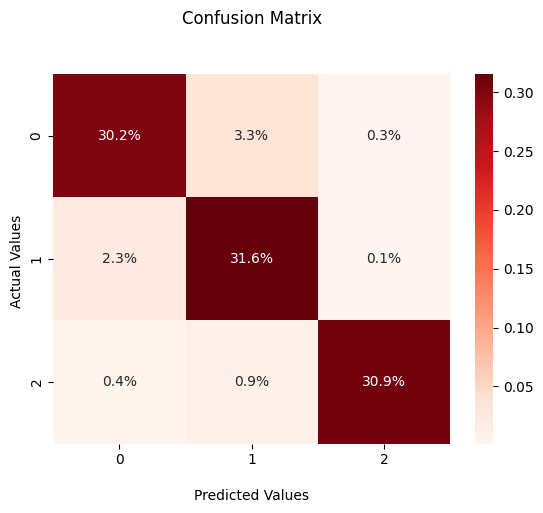

SUBJECT 4
6/6 [==============================] - 0s 5ms/step - loss: 0.9089 - accuracy: 0.7459
Score : loss of 0.9089401364326477; accuracy of 74.59016442298889%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.7402545650646079
Precision:  0.7797533810368305
Recall:  0.7459016393442623


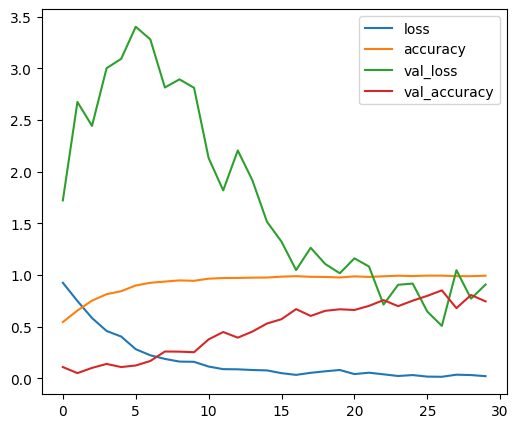

[[215  15  11]
 [ 23 208  14]
 [113  10 123]]


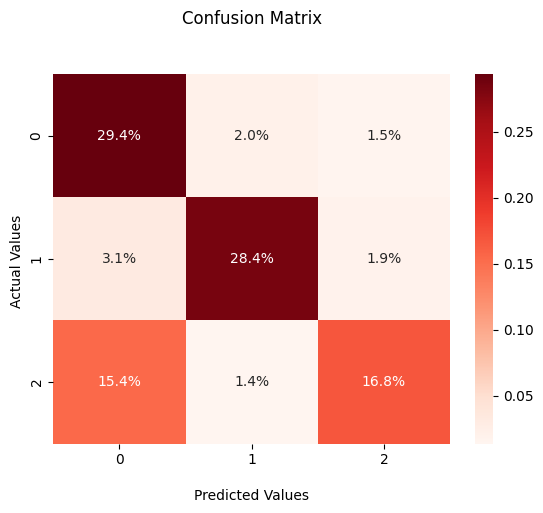

SUBJECT 5
6/6 [==============================] - 0s 5ms/step - loss: 0.5655 - accuracy: 0.8033
Score : loss of 0.5655495524406433; accuracy of 80.32786846160889%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.8042665194555518
Precision:  0.8065201267110377
Recall:  0.8032786885245902


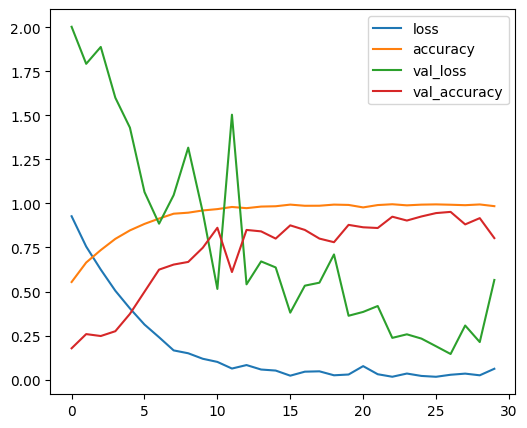

[[191   8  42]
 [ 12 205  30]
 [ 28  24 192]]


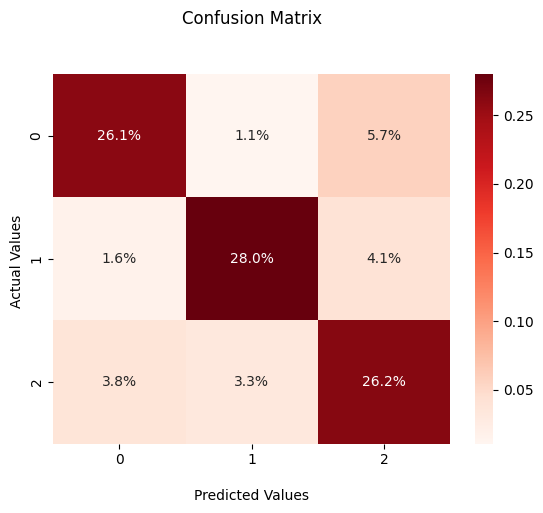

SUBJECT 6
6/6 [==============================] - 0s 5ms/step - loss: 0.1780 - accuracy: 0.9380
Score : loss of 0.1780034601688385; accuracy of 93.80053877830505%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.9379855361956103
Precision:  0.938972087866641
Recall:  0.9380053908355795


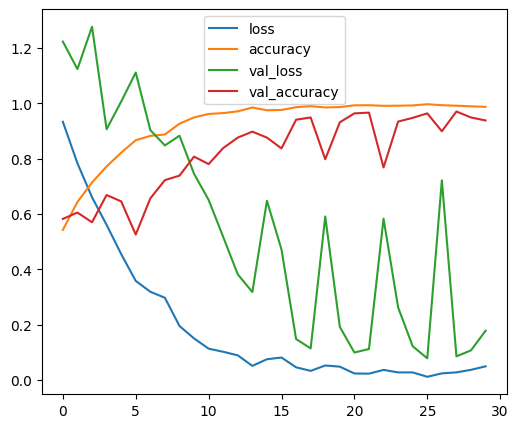

[[233   0  19]
 [  2 244   3]
 [  3  19 219]]


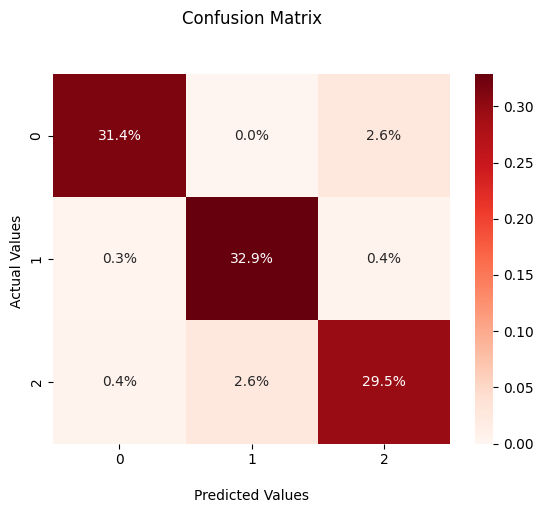

SUBJECT 7
6/6 [==============================] - 0s 5ms/step - loss: 0.2872 - accuracy: 0.9375
Score : loss of 0.2872428596019745; accuracy of 93.75%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.937747693599781
Precision:  0.9384917999457848
Recall:  0.9375


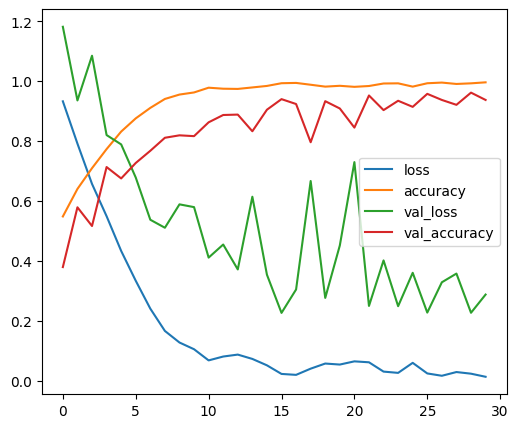

[[234   9   6]
 [  4 226  14]
 [  0  13 230]]


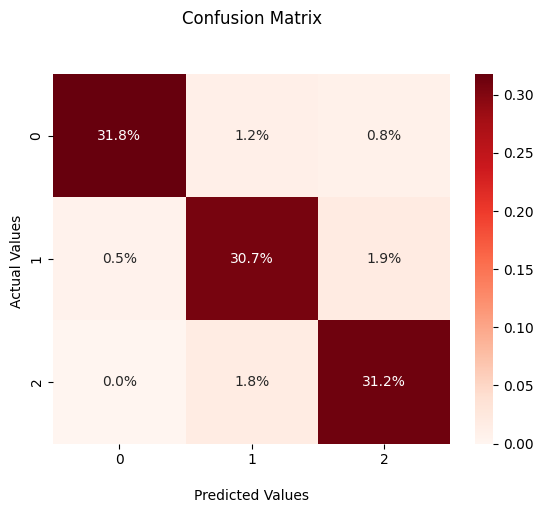

SUBJECT 8
6/6 [==============================] - 0s 5ms/step - loss: 0.2705 - accuracy: 0.9331
Score : loss of 0.27045315504074097; accuracy of 93.30543875694275%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.9327958960213566
Precision:  0.9342957305496895
Recall:  0.9330543933054394


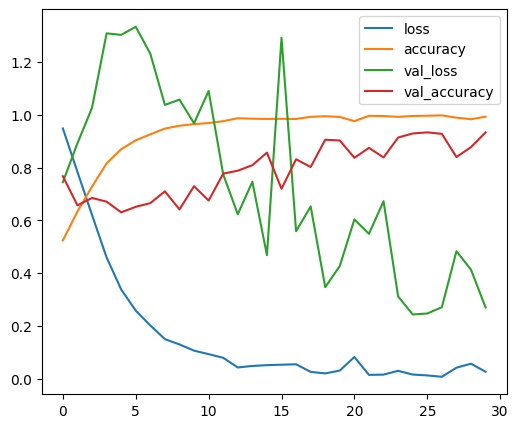

[[219  11  11]
 [ 10 219  13]
 [  1   2 231]]


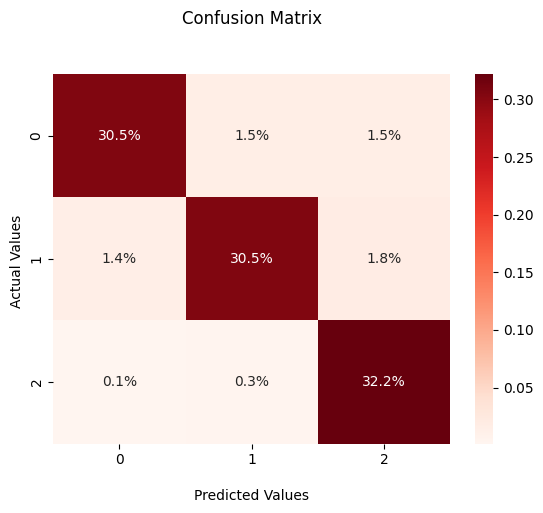

SUBJECT 9
6/6 [==============================] - 0s 5ms/step - loss: 0.0974 - accuracy: 0.9604
Score : loss of 0.09742361307144165; accuracy of 96.03825211524963%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.9605415659268625
Precision:  0.9619292814558549
Recall:  0.9603825136612022


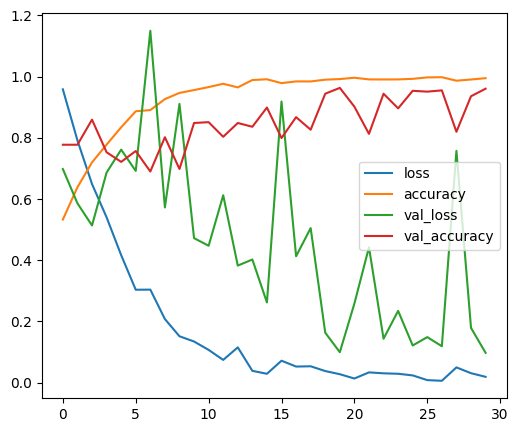

[[229  13   3]
 [  0 245   6]
 [  0   7 229]]


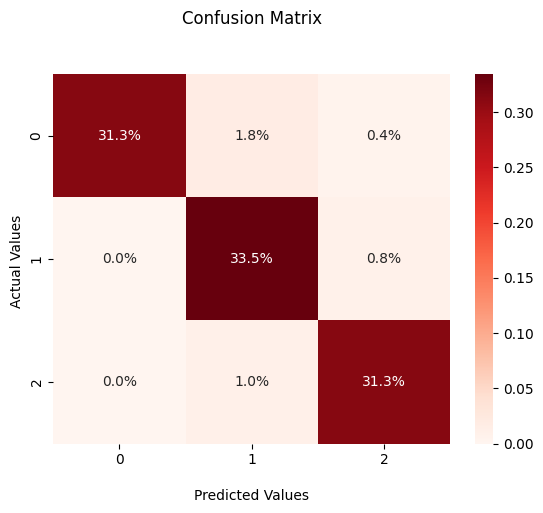

SUBJECT 10
6/6 [==============================] - 0s 5ms/step - loss: 0.1786 - accuracy: 0.9752
Score : loss of 0.1785992532968521; accuracy of 97.52281904220581%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.9751529621003048
Precision:  0.9751738472979693
Recall:  0.9752281616688396


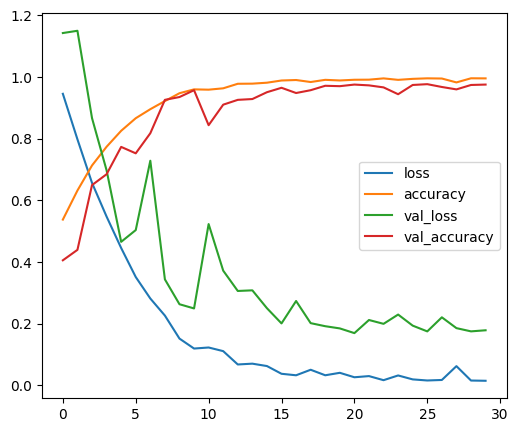

[[244   6   5]
 [  8 257   0]
 [  0   0 247]]


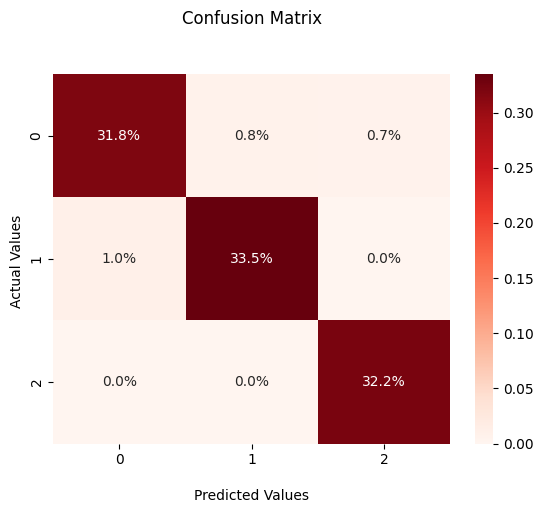

SUBJECT 11
6/6 [==============================] - 0s 5ms/step - loss: 0.2368 - accuracy: 0.9198
Score : loss of 0.23675569891929626; accuracy of 91.9836938381195%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.9194162237152377
Precision:  0.9193211561922748
Recall:  0.9198369565217391


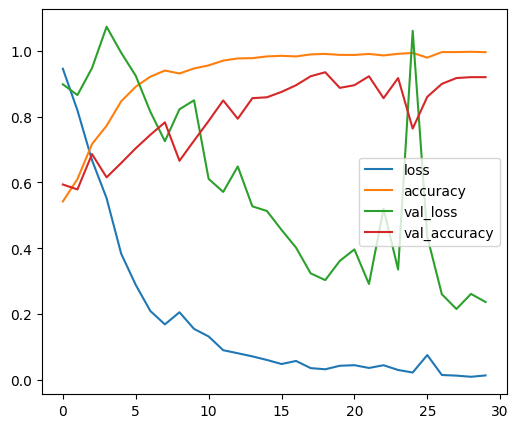

[[234   4   0]
 [  8 225  22]
 [  5  20 218]]


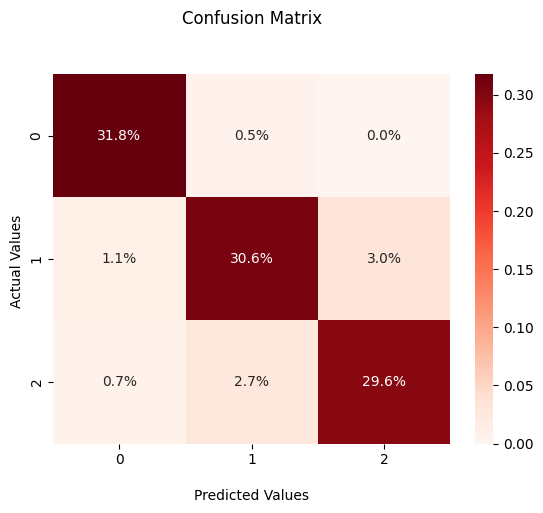

SUBJECT 12
6/6 [==============================] - 0s 5ms/step - loss: 0.3299 - accuracy: 0.8747
Score : loss of 0.32985642552375793; accuracy of 87.46556639671326%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.8731366349331996
Precision:  0.8744202878676582
Recall:  0.8746556473829201


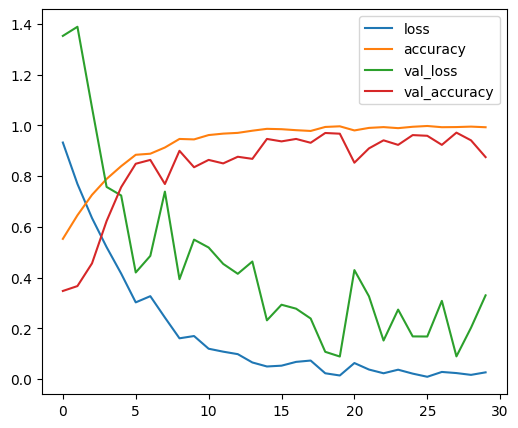

[[188  19  24]
 [ 38 201   6]
 [  0   4 246]]


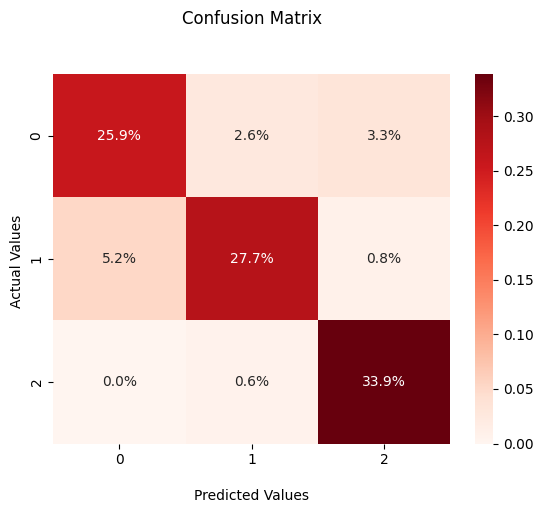

SUBJECT 13
6/6 [==============================] - 0s 5ms/step - loss: 0.2032 - accuracy: 0.9319
Score : loss of 0.2031906545162201; accuracy of 93.18801164627075%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.9320393172065832
Precision:  0.9367516595505754
Recall:  0.9318801089918256


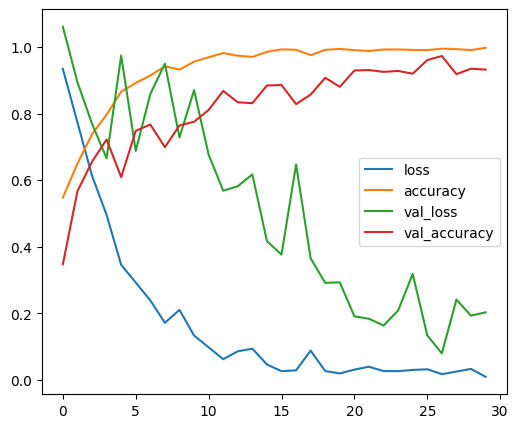

[[239  11   0]
 [  8 237   0]
 [  8  23 208]]


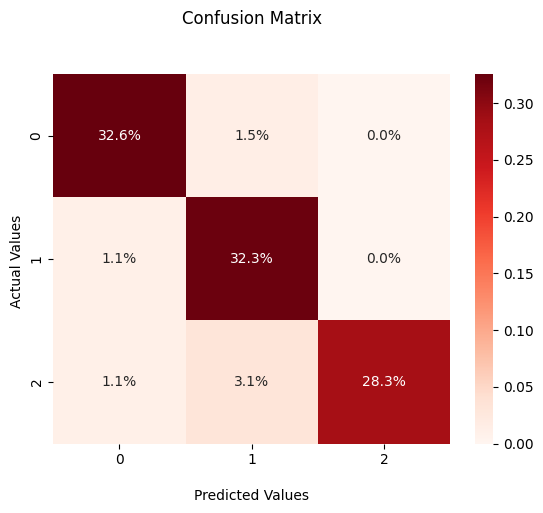

SUBJECT 14
6/6 [==============================] - 0s 5ms/step - loss: 0.5446 - accuracy: 0.9269
Score : loss of 0.5446328520774841; accuracy of 92.68617033958435%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.9274931726955027
Precision:  0.9304628782002641
Recall:  0.9268617021276596


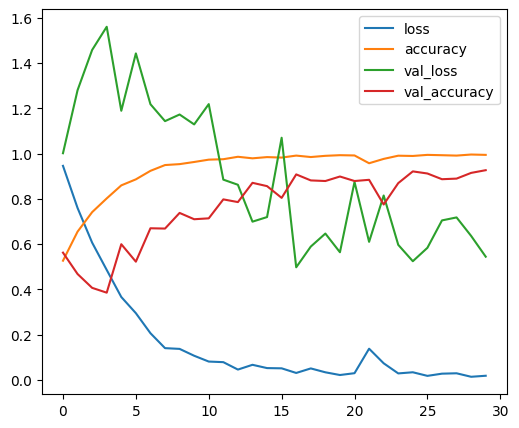

[[220  17   1]
 [  3 244  10]
 [  2  22 233]]


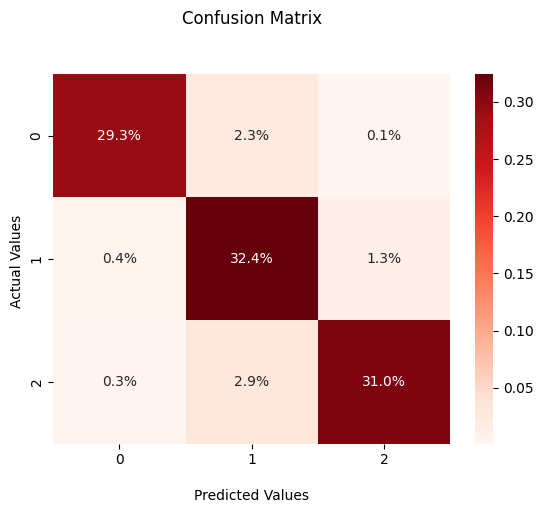

SUBJECT 15
6/6 [==============================] - 0s 5ms/step - loss: 0.1655 - accuracy: 0.9477
Score : loss of 0.16550786793231964; accuracy of 94.77304220199585%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.9479038743355582
Precision:  0.9499696776297617
Recall:  0.9477303988995873


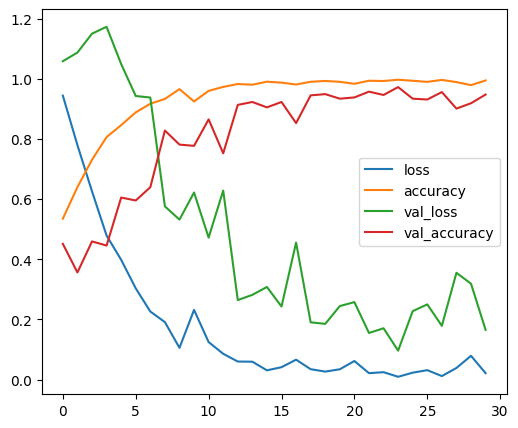

[[227   1  22]
 [  7 231   4]
 [  4   0 231]]


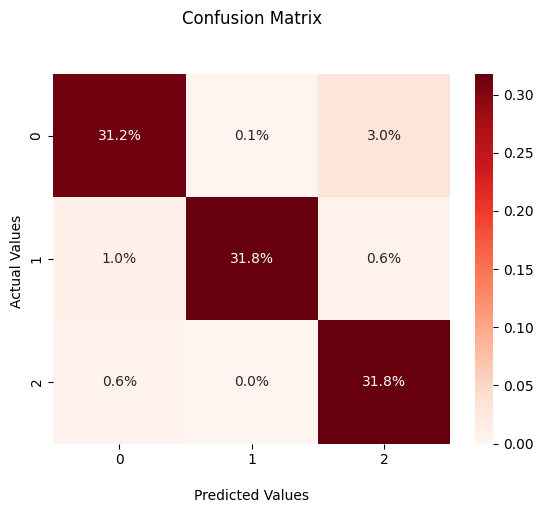

SUBJECT 16
6/6 [==============================] - 0s 5ms/step - loss: 0.2013 - accuracy: 0.9218
Score : loss of 0.2013229876756668; accuracy of 92.18328595161438%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.922108163726049
Precision:  0.9239015120294198
Recall:  0.921832884097035


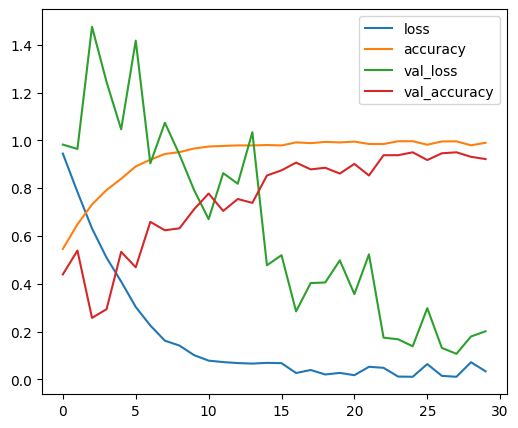

[[224  28   0]
 [  7 233   5]
 [ 14   4 227]]


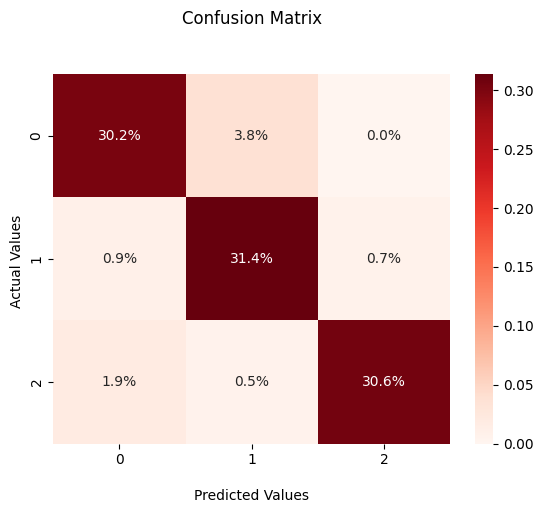

SUBJECT 17
6/6 [==============================] - 0s 5ms/step - loss: 0.3770 - accuracy: 0.9144
Score : loss of 0.37696021795272827; accuracy of 91.44384860992432%
24/24 [==============================] - 0s 4ms/step
F1 score:  0.9144791770403308
Precision:  0.9149979826460709
Recall:  0.9144385026737968


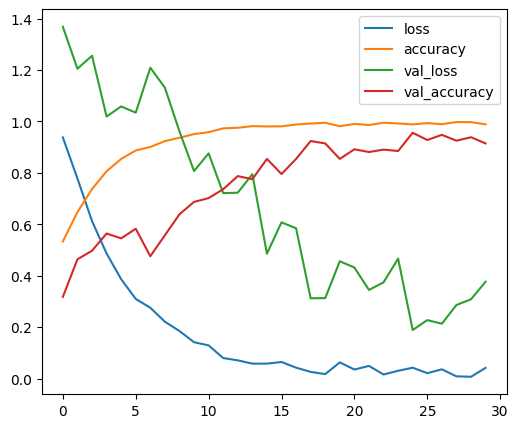

[[244  13   3]
 [ 14 225  10]
 [  9  15 215]]


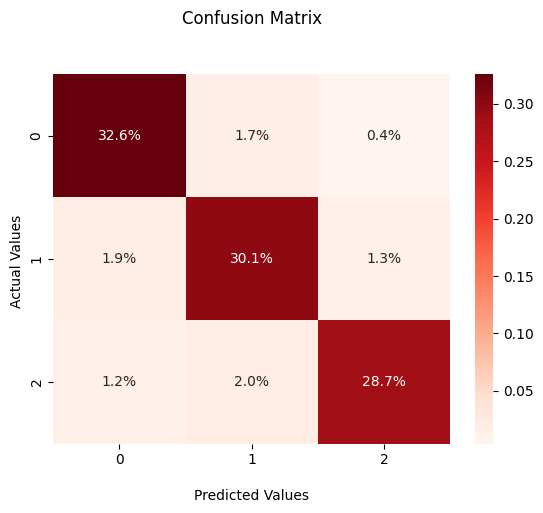

SUBJECT 18
6/6 [==============================] - 0s 5ms/step - loss: 0.2853 - accuracy: 0.9136
Score : loss of 0.28528574109077454; accuracy of 91.36302471160889%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.9126967207587401
Precision:  0.9158299826066962
Recall:  0.9136302294197031


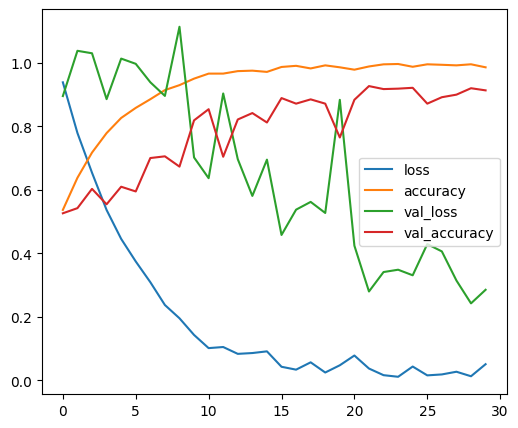

[[234  16   1]
 [ 42 198   5]
 [  0   0 245]]


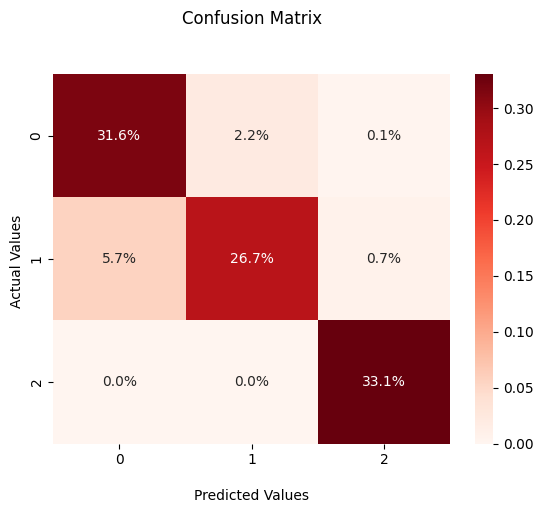

SUBJECT 19
6/6 [==============================] - 0s 5ms/step - loss: 0.0941 - accuracy: 0.9723
Score : loss of 0.09411116689443588; accuracy of 97.23374843597412%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.9723063988188166
Precision:  0.9736650415193573
Recall:  0.9723374827109267


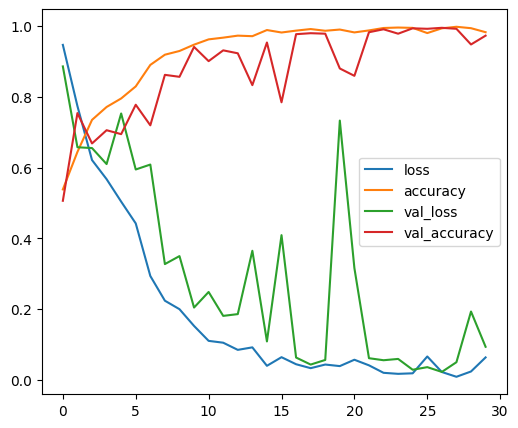

[[241   0   3]
 [ 17 224   0]
 [  0   0 238]]


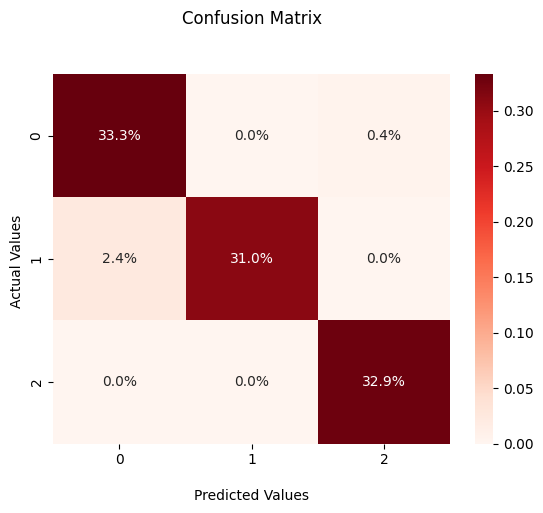

SUBJECT 20
6/6 [==============================] - 0s 5ms/step - loss: 0.0672 - accuracy: 0.9756
Score : loss of 0.0672411173582077; accuracy of 97.5576639175415%
24/24 [==============================] - 0s 3ms/step
F1 score:  0.9756675659700064
Precision:  0.9759101871463083
Recall:  0.9755766621438263


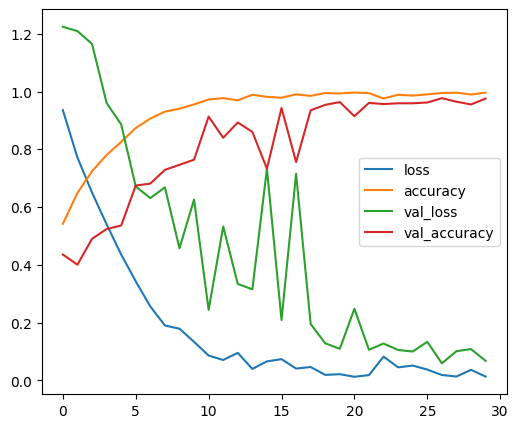

[[234   0   6]
 [  4 235   0]
 [  8   0 250]]


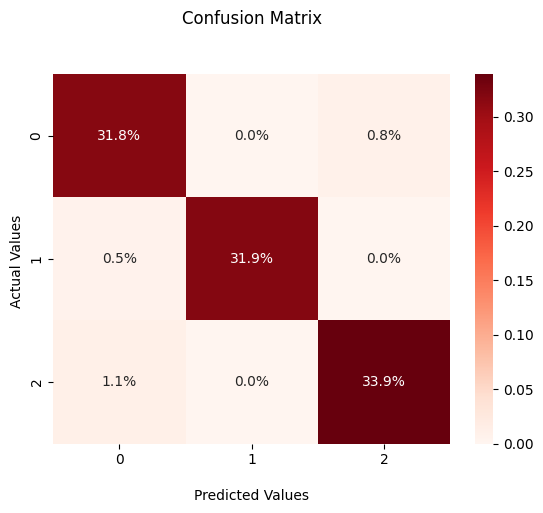

SUBJECT 21
6/6 [==============================] - 0s 5ms/step - loss: 0.4226 - accuracy: 0.8786
Score : loss of 0.4226466119289398; accuracy of 87.86206841468811%
23/23 [==============================] - 0s 3ms/step
F1 score:  0.8783027978764582
Precision:  0.8784491105784779
Recall:  0.8786206896551724


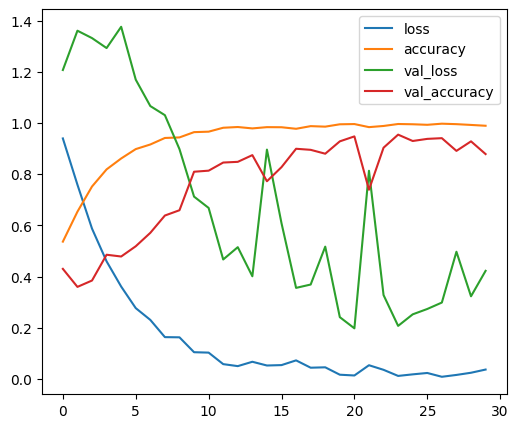

[[211   3  22]
 [ 12 222   9]
 [ 20  22 204]]


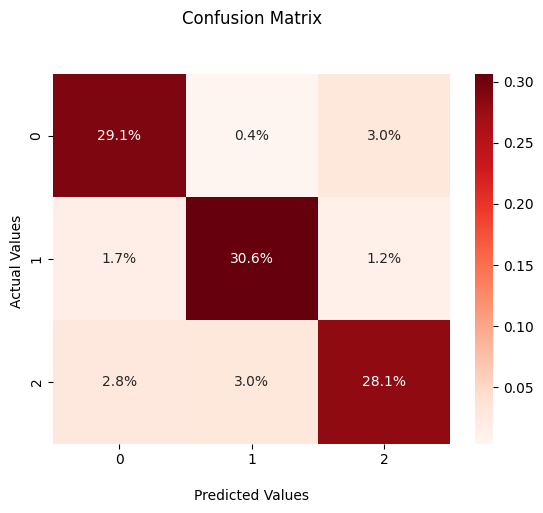

In [ ]:
from sklearn.model_selection import train_test_split

for sub in range(len(all_data)):

    print('SUBJECT',sub)

    test_data_all = all_data[sub]

    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(test_data_all['data'], test_data_all['label'], test_size=0.2, random_state=3456789)

    train_data, train_data_all = {}, {}
    test_data = {}
    
    train_data_all["data"] = np.concatenate([all_data[i]["data"] for i in range(len(all_data)) if i != sub])    
    train_data['data'] = np.concatenate((train_data_all['data'], X_test_split), axis=0)
    
    train_data_all["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])
    train_data["label"] = np.concatenate((train_data_all["label"], y_test_split), axis=0)
    
    test_data['data'] = X_train_split
    test_data['label'] = y_train_split

    cm_w_ft_20, acc_w_ft_20, loss_w_ft_20, f1_w_ft_20, prec_w_ft_20, rec_w_ft_20 = lstm(train_data, test_data)

#**Average accuracy and F1 score (20% ft)**

In [11]:
print(acc_w_ft_20)

[97.146737575531, 74.05914068222046, 94.86486315727234, 92.68292784690857, 74.59016442298889, 80.32786846160889, 93.80053877830505, 93.75, 93.30543875694275, 96.03825211524963, 97.52281904220581, 91.9836938381195, 87.46556639671326, 93.18801164627075, 92.68617033958435, 94.77304220199585, 92.18328595161438, 91.44384860992432, 91.36302471160889, 97.23374843597412, 97.5576639175415, 87.86206841468811]


In [12]:
print(np.mean(acc_w_ft_20))
print(np.mean(f1_w_ft_20))

91.17403978651221
0.911304503912093


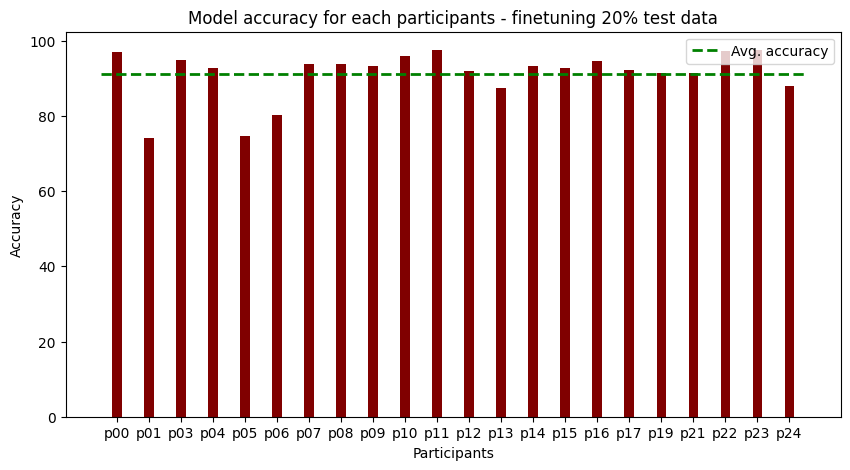

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_ft_20, color ='maroon',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("Model accuracy for each participants - finetuning 20% test data")

plt.hlines(y=(np.mean(acc_w_ft_20)), xmin=-0.5, xmax=(len(acc_w_ft_20)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

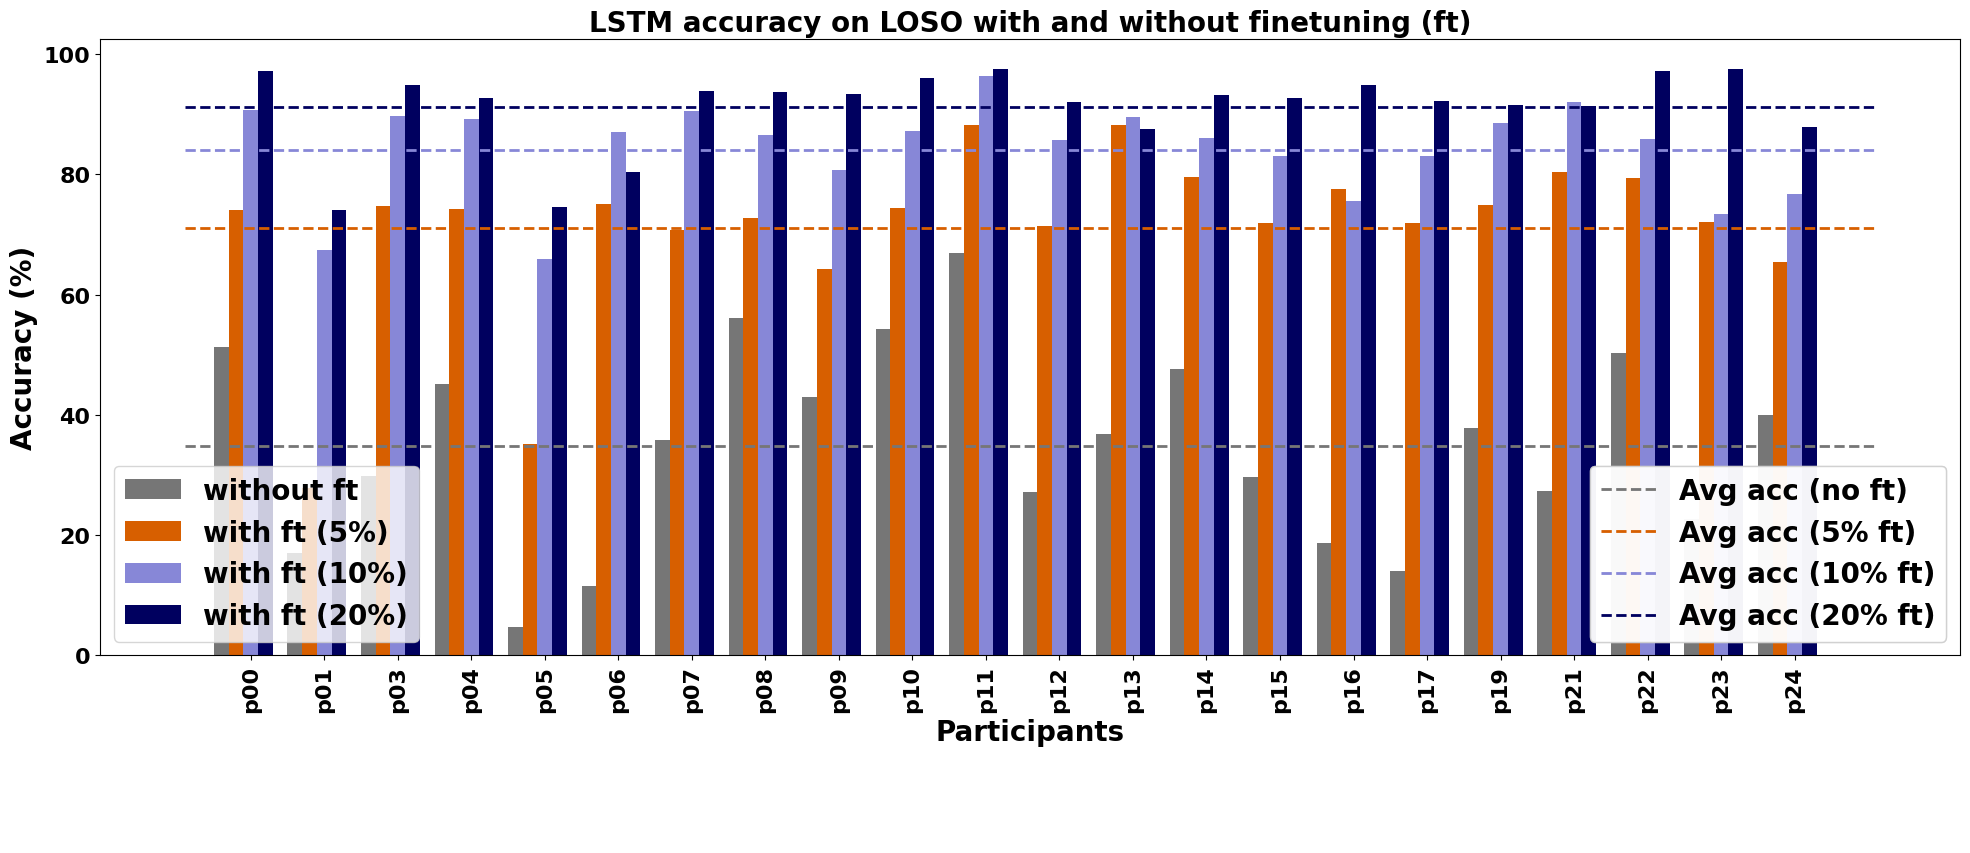

In [16]:
import matplotlib.font_manager as font_manager

N = 22
ind = np.arange(N) 
width = 0.2

plt.rcParams['figure.figsize'] = [24, 8]
wo_ft = acc_w_o_ft
bar1 = plt.bar(ind, wo_ft, width, color = '#767676')

w_ft_5 = acc_w_ft_5
bar2 = plt.bar(ind+width, w_ft_5, width, color = '#d75f00')
  
w_ft_10 = acc_w_ft_10
bar3 = plt.bar(ind+width*2, w_ft_10, width, color='#8787d7')
  
w_ft_20 = acc_w_ft_20
bar4 = plt.bar(ind+width*3, w_ft_20, width, color = '#00005f')

font = font_manager.FontProperties(weight='bold', style='normal', size=20)
  
plt.xlabel("Participants\n\n\n",fontsize=20, fontweight='bold')
plt.ylabel('Accuracy (%)',fontsize=20, fontweight='bold')
plt.title("LSTM accuracy on LOSO with and without finetuning (ft)", fontsize=20, fontweight='bold')
  
plt.xticks(ind+width*2,participants)
plt.xticks(fontsize=16, rotation=90, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
legend1 = plt.legend( (bar1, bar2, bar3, bar4), ('without ft', 'with ft (5%)', 'with ft (10%)', 'with ft (20%)'), loc = 3, prop=font)

plt.hlines(y=(np.mean(wo_ft)), xmin=-0.5, xmax=(len(wo_ft)+0.5), colors='#767676', lw=2, label='Avg acc (no ft)', linestyles='--')
plt.hlines(y=(np.mean(w_ft_5)), xmin=-0.5, xmax=(len(w_ft_5)+0.5), colors='#d75f00', lw=2, label='Avg acc (5% ft)', linestyles='--')
plt.hlines(y=(np.mean(w_ft_10)), xmin=-0.5, xmax=(len(w_ft_10)+0.5), colors='#8787d7', lw=2, label='Avg acc (10% ft)', linestyles='--')
plt.hlines(y=(np.mean(w_ft_20)), xmin=-0.5, xmax=(len(w_ft_20)+0.5), colors='#00005f', lw=2, label='Avg acc (20% ft)', linestyles='--')
legend2 = plt.legend( loc = 4, prop=font)

plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

#plt.savefig('lstm_LOSO_all.pdf') 
plt.show()